# 基于XGBoost和滑动窗口的飞机发动机损坏传播建模

本notebook专注于使用XGBoost算法结合**滑动窗口时间序列**方法对NASA C-MAPS数据集中的飞机发动机数据进行预测性维护建模。

## 主要特点：
1. **时间序列滑动窗口**：使用历史50个周期的传感器数据进行预测
2. **回归任务**：预测发动机的剩余使用寿命（RUL）
3. **分类任务**：判断发动机是否在10个周期内需要维护
4. **多时间点预测**：对每个发动机的多个时间点进行滚动预测

### 参考数据集来源
- NASA C-MAPS Turbofan Engine Degradation Simulation Data Set
- [Data Source](https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#turbofan)

### 滑动窗口方法说明
- **窗口大小**：50个时间周期
- **滑动步长**：1个时间周期
- **特征维度**：14个传感器特征 × 50个时间周期 = 700维特征向量

In [1]:
# 导入所需的库
import pandas as pd
import numpy as np
import sklearn
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
import math
import xgboost
import time
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# 设置图形显示参数
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
rcParams['figure.figsize'] = 10, 8

# 设置随机种子以确保结果可重现
np.random.seed(1234)  
PYTHONHASHSEED = 0

print("所有库导入成功！")
print(f"pandas版本: {pd.__version__}")
print(f"numpy版本: {np.__version__}")
print(f"scikit-learn版本: {sklearn.__version__}")
print(f"xgboost版本: {xgboost.__version__}")

# 滑动窗口参数设置
WINDOW_SIZE = 50  # 滑动窗口大小
print(f"\n滑动窗口设置:")
print(f"窗口大小: {WINDOW_SIZE} 个时间周期")
print(f"滑动步长: 1 个时间周期")

所有库导入成功！
pandas版本: 2.3.3
numpy版本: 1.23.5
scikit-learn版本: 1.7.2
xgboost版本: 3.1.1

滑动窗口设置:
窗口大小: 50 个时间周期
滑动步长: 1 个时间周期


## 1. 数据加载与初步探索

In [2]:
# 加载训练数据
print("正在加载训练数据...")
fd_001_train = pd.read_csv("./CMaps/train_FD001.txt", sep=" ", header=None)
print(f"训练数据形状: {fd_001_train.shape}")

# 加载测试数据
print("正在加载测试数据...")
fd_001_test = pd.read_csv("./CMaps/test_FD001.txt", sep=" ", header=None)
print(f"测试数据形状: {fd_001_test.shape}")

print("\n数据加载完成！")

正在加载训练数据...
训练数据形状: (20631, 28)
正在加载测试数据...
测试数据形状: (13096, 28)

数据加载完成！


In [3]:
# 查看训练数据的基本信息
print("=== 训练数据基本信息 ===")
print(f"数据形状: {fd_001_train.shape}")
print(f"列数: {fd_001_train.shape[1]}")
print(f"行数: {fd_001_train.shape[0]}")
print("\n数据类型:")
print(fd_001_train.dtypes)
print("\n缺失值统计:")
print(fd_001_train.isnull().sum())

=== 训练数据基本信息 ===
数据形状: (20631, 28)
列数: 28
行数: 20631

数据类型:
0       int64
1       int64
2     float64
3     float64
4     float64
5     float64
6     float64
7     float64
8     float64
9     float64
10    float64
11    float64
12    float64
13    float64
14    float64
15    float64
16    float64
17    float64
18    float64
19    float64
20    float64
21      int64
22      int64
23    float64
24    float64
25    float64
26    float64
27    float64
dtype: object

缺失值统计:
0         0
1         0
2         0
3         0
4         0
5         0
6         0
7         0
8         0
9         0
10        0
11        0
12        0
13        0
14        0
15        0
16        0
17        0
18        0
19        0
20        0
21        0
22        0
23        0
24        0
25        0
26    20631
27    20631
dtype: int64


In [4]:
# 查看训练数据的前几行和后几行
print("训练数据前5行:")
display(fd_001_train.head())

print("\n训练数据后5行:")
display(fd_001_train.tail())

训练数据前5行:


,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN



训练数据后5行:


,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,NaN,NaN
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,NaN,NaN
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,NaN,NaN
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,NaN,NaN
20630,100,200,-0.0032,-0.0005,100.0,518.67,643.85,1600.38,1432.14,14.62,...,8137.33,8.5036,0.03,396,2388,100.0,38.37,23.0522,NaN,NaN


In [5]:
# 查看训练数据的统计描述
print("训练数据统计描述:")
display(fd_001_train.describe())

训练数据统计描述:


,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,20631.00,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000,0.0,0.0
mean,51.506568,108.807862,-0.000009,0.000002,100.0,518.67,642.680934,1590.523119,1408.933782,1.462000e+01,...,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705,NaN,NaN
std,29.227633,68.880990,0.002187,0.000293,0.0,0.00,0.500053,6.131150,9.000605,1.776400e-15,...,19.076176,0.037505,1.387812e-17,1.548763,0.0,0.0,0.180746,0.108251,NaN,NaN
min,1.000000,1.000000,-0.008700,-0.000600,100.0,518.67,641.210000,1571.040000,1382.250000,1.462000e+01,...,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200,NaN,NaN
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,518.67,642.325000,1586.260000,1402.360000,1.462000e+01,...,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800,NaN,NaN
50%,52.000000,104.000000,0.000000,0.000000,100.0,518.67,642.640000,1590.100000,1408.040000,1.462000e+01,...,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900,NaN,NaN
75%,77.000000,156.000000,0.001500,0.000300,100.0,518.67,643.000000,1594.380000,1414.555000,1.462000e+01,...,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800,NaN,NaN
max,100.000000,362.000000,0.008700,0.000600,100.0,518.67,644.530000,1616.910000,1441.490000,1.462000e+01,...,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400,NaN,NaN


In [6]:
# 检查数据中的唯一值
print("各列的唯一值数量:")
for col in fd_001_train.columns:
    unique_count = fd_001_train[col].nunique()
    print(f"列 {col}: {unique_count} 个唯一值")
    
    # 如果唯一值很少，显示具体值
    if unique_count <= 10:
        print(f"  唯一值: {sorted(fd_001_train[col].unique())}")
    print()

各列的唯一值数量:
列 0: 100 个唯一值

列 1: 362 个唯一值

列 2: 158 个唯一值

列 3: 13 个唯一值

列 4: 1 个唯一值
  唯一值: [100.0]

列 5: 1 个唯一值
  唯一值: [518.67]

列 6: 310 个唯一值

列 7: 3012 个唯一值

列 8: 4051 个唯一值

列 9: 1 个唯一值
  唯一值: [14.62]

列 10: 2 个唯一值
  唯一值: [21.6, 21.61]

列 11: 513 个唯一值

列 12: 53 个唯一值

列 13: 6403 个唯一值

列 14: 1 个唯一值
  唯一值: [1.3]

列 15: 159 个唯一值

列 16: 427 个唯一值

列 17: 56 个唯一值

列 18: 6078 个唯一值

列 19: 1918 个唯一值

列 20: 1 个唯一值
  唯一值: [0.03]

列 21: 13 个唯一值

列 22: 1 个唯一值
  唯一值: [2388]

列 23: 1 个唯一值
  唯一值: [100.0]

列 24: 120 个唯一值

列 25: 4745 个唯一值

列 26: 0 个唯一值
  唯一值: [nan]

列 27: 0 个唯一值
  唯一值: [nan]



### 数据清洗

In [7]:
# 删除空列（第26和27列）
print("删除前的列数:", fd_001_train.shape[1])
fd_001_train.drop(columns=[26,27], inplace=True)
fd_001_test.drop(columns=[26,27], inplace=True)
print("删除后的列数:", fd_001_train.shape[1])
print("空列删除完成！")

删除前的列数: 28
删除后的列数: 26
空列删除完成！


In [8]:
# 定义列名
columns = ['unit_number','time_in_cycles','setting_1','setting_2','TRA','T2','T24','T30','T50','P2','P15','P30','Nf',
           'Nc','epr','Ps30','phi','NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32']

print(f"列名数量: {len(columns)}")
print(f"数据列数: {fd_001_train.shape[1]}")

# 为数据设置列名
fd_001_train.columns = columns
fd_001_test.columns = columns

print("列名设置完成！")
print("\n设置列名后的训练数据:")
display(fd_001_train.head())

列名数量: 26
数据列数: 26
列名设置完成！

设置列名后的训练数据:


,unit_number,time_in_cycles,setting_1,setting_2,TRA,T2,T24,T30,T50,P2,...,phi,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [9]:
# 删除常数列，这些列不包含关于发动机状态的信息
columns_to_drop = ['Nf_dmd','PCNfR_dmd','P2','T2','TRA','farB','epr']
print(f"要删除的列: {columns_to_drop}")

print(f"\n删除前的训练数据形状: {fd_001_train.shape}")
print(f"删除前的测试数据形状: {fd_001_test.shape}")

fd_001_train.drop(columns=columns_to_drop, inplace=True)
fd_001_test.drop(columns=columns_to_drop, inplace=True)

print(f"\n删除后的训练数据形状: {fd_001_train.shape}")
print(f"删除后的测试数据形状: {fd_001_test.shape}")
print("常数列删除完成！")

要删除的列: ['Nf_dmd', 'PCNfR_dmd', 'P2', 'T2', 'TRA', 'farB', 'epr']

删除前的训练数据形状: (20631, 26)
删除前的测试数据形状: (13096, 26)

删除后的训练数据形状: (20631, 19)
删除后的测试数据形状: (13096, 19)
常数列删除完成！


### 探索发动机数据分布

In [10]:
# 查看发动机数量和每个发动机的数据点
num_engines_train = fd_001_train['unit_number'].nunique()
num_engines_test = fd_001_test['unit_number'].nunique()

print(f"训练数据中的发动机数量: {num_engines_train}")
print(f"测试数据中的发动机数量: {num_engines_test}")

# 查看每个发动机的数据点数量
train_cycles = fd_001_train.groupby('unit_number')['time_in_cycles'].max()
test_cycles = fd_001_test.groupby('unit_number')['time_in_cycles'].max()

print(f"\n训练数据中每个发动机的周期统计:")
print(f"平均周期数: {train_cycles.mean():.1f}")
print(f"最小周期数: {train_cycles.min()}")
print(f"最大周期数: {train_cycles.max()}")

print(f"\n测试数据中每个发动机的周期统计:")
print(f"平均周期数: {test_cycles.mean():.1f}")
print(f"最小周期数: {test_cycles.min()}")
print(f"最大周期数: {test_cycles.max()}")

# 检查滑动窗口的适用性
print(f"\n滑动窗口适用性检查:")
print(f"窗口大小: {WINDOW_SIZE}")
print(f"训练数据中周期数 >= {WINDOW_SIZE} 的发动机: {(train_cycles >= WINDOW_SIZE).sum()} / {len(train_cycles)}")
print(f"测试数据中周期数 >= {WINDOW_SIZE} 的发动机: {(test_cycles >= WINDOW_SIZE).sum()} / {len(test_cycles)}")

训练数据中的发动机数量: 100
测试数据中的发动机数量: 100

训练数据中每个发动机的周期统计:
平均周期数: 206.3
最小周期数: 128
最大周期数: 362

测试数据中每个发动机的周期统计:
平均周期数: 131.0
最小周期数: 31
最大周期数: 303

滑动窗口适用性检查:
窗口大小: 50
训练数据中周期数 >= 50 的发动机: 100 / 100
测试数据中周期数 >= 50 的发动机: 93 / 100


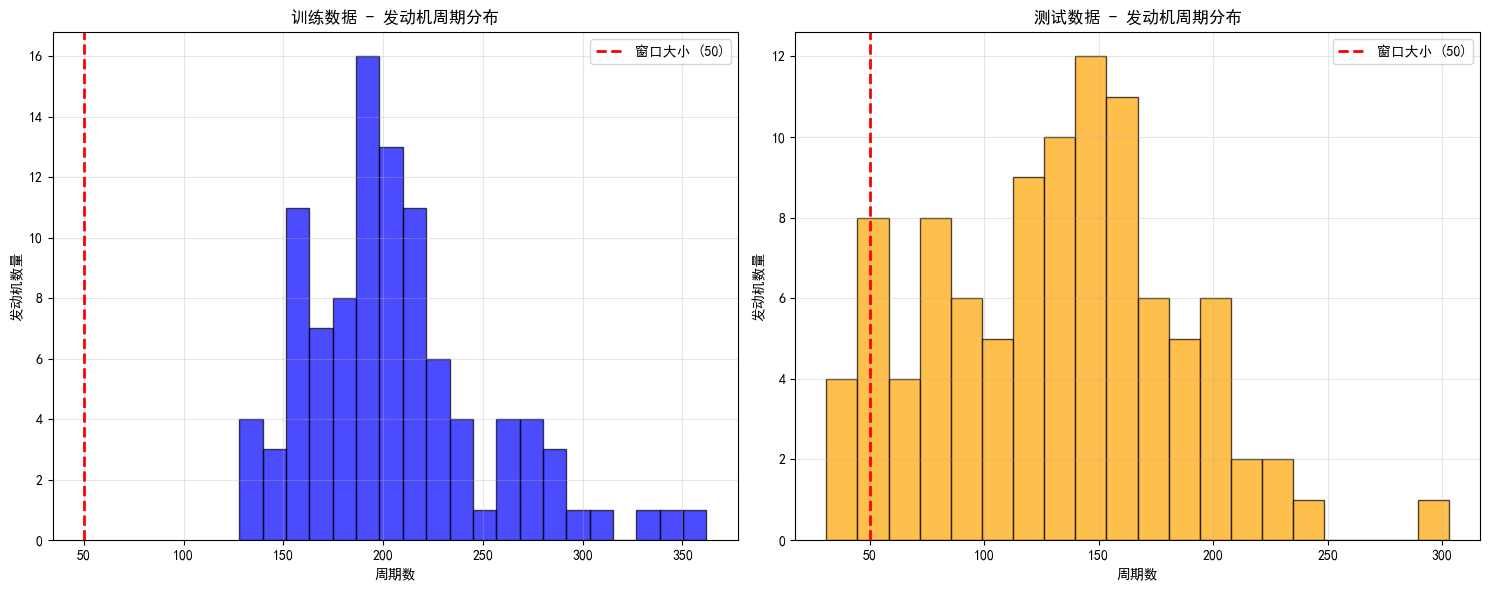

In [11]:
# 可视化发动机周期分布
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# 训练数据周期分布
ax1.hist(train_cycles, bins=20, alpha=0.7, color='blue', edgecolor='black')
ax1.axvline(x=WINDOW_SIZE, color='red', linestyle='--', linewidth=2, label=f'窗口大小 ({WINDOW_SIZE})')
ax1.set_title('训练数据 - 发动机周期分布')
ax1.set_xlabel('周期数')
ax1.set_ylabel('发动机数量')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 测试数据周期分布
ax2.hist(test_cycles, bins=20, alpha=0.7, color='orange', edgecolor='black')
ax2.axvline(x=WINDOW_SIZE, color='red', linestyle='--', linewidth=2, label=f'窗口大小 ({WINDOW_SIZE})')
ax2.set_title('测试数据 - 发动机周期分布')
ax2.set_xlabel('周期数')
ax2.set_ylabel('发动机数量')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 创建RUL（剩余使用寿命）目标变量

In [12]:
# 准备训练数据并形成RUL列，包含距离故障的剩余周期数
def prepare_train_data(data, factor=0):
    """
    准备训练数据并计算RUL
    
    参数:
    - data: 原始数据
    - factor: 要排除的早期周期数
    
    返回:
    - 包含RUL列的数据框
    """
    df = data.copy()
    
    # 计算每个发动机的最大周期数
    fd_RUL = df.groupby('unit_number')['time_in_cycles'].max().reset_index()
    fd_RUL = pd.DataFrame(fd_RUL)
    fd_RUL.columns = ['unit_number','max']
    
    # 合并最大周期数到原始数据
    df = df.merge(fd_RUL, on=['unit_number'], how='left')
    
    # 计算RUL = 最大周期数 - 当前周期数
    df['RUL'] = df['max'] - df['time_in_cycles']
    df.drop(columns=['max'], inplace=True)
    
    # 只保留大于factor的周期
    return df[df['time_in_cycles'] > factor]

# 准备训练数据
print("正在准备训练数据...")
df = prepare_train_data(fd_001_train)
print(f"准备后的训练数据形状: {df.shape}")
print("训练数据准备完成！")

正在准备训练数据...
准备后的训练数据形状: (20631, 20)
训练数据准备完成！


In [13]:
# 查看添加RUL后的数据
print("添加RUL后的数据样本:")
display(df.head())

print("\nRUL统计信息:")
print(df['RUL'].describe())

print("\nRUL分布:")
print(f"最小RUL: {df['RUL'].min()}")
print(f"最大RUL: {df['RUL'].max()}")
print(f"平均RUL: {df['RUL'].mean():.1f}")

添加RUL后的数据样本:


,unit_number,time_in_cycles,setting_1,setting_2,T24,T30,T50,P15,P30,Nf,Nc,Ps30,phi,NRf,NRc,BPR,htBleed,W31,W32,RUL
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,21.61,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,21.61,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,21.61,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,21.61,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,21.61,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,187



RUL统计信息:
count    20631.000000
mean       107.807862
std         68.880990
min          0.000000
25%         51.000000
50%        103.000000
75%        155.000000
max        361.000000
Name: RUL, dtype: float64

RUL分布:
最小RUL: 0
最大RUL: 361
平均RUL: 107.8


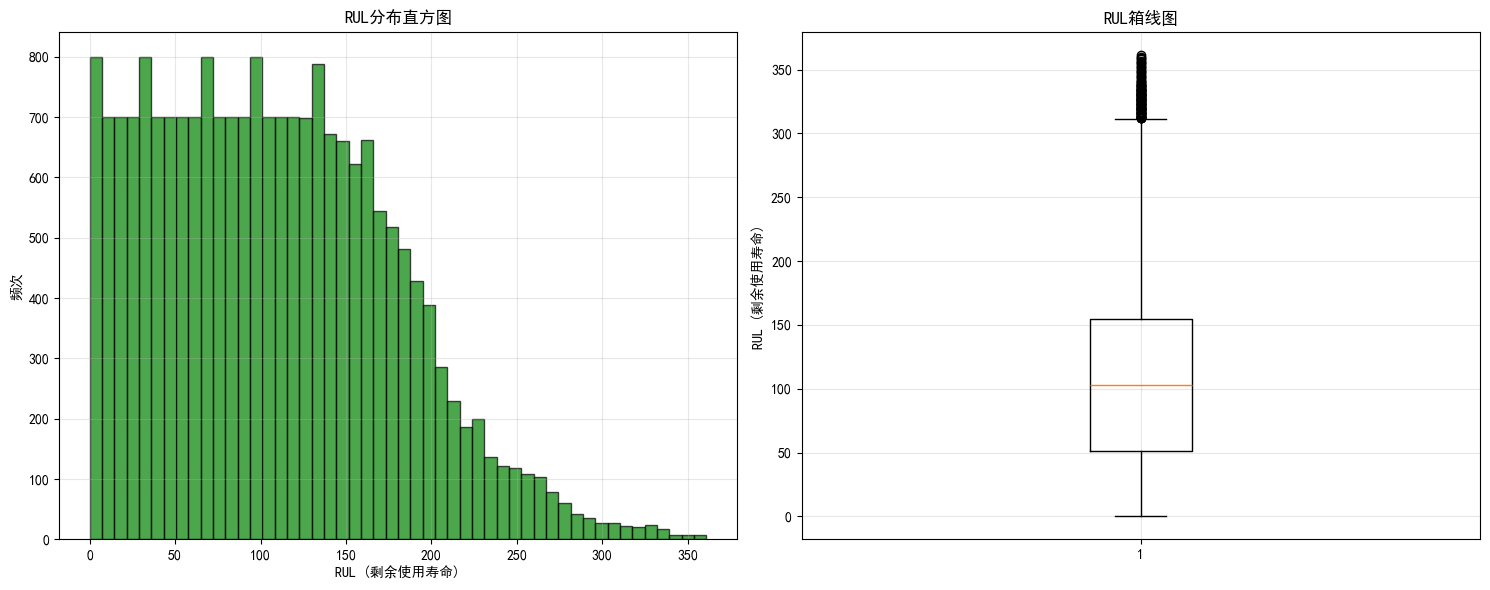

In [14]:
# 可视化RUL分布
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# RUL分布直方图
ax1.hist(df['RUL'], bins=50, alpha=0.7, color='green', edgecolor='black')
ax1.set_title('RUL分布直方图')
ax1.set_xlabel('RUL (剩余使用寿命)')
ax1.set_ylabel('频次')
ax1.grid(True, alpha=0.3)

# RUL箱线图
ax2.boxplot(df['RUL'])
ax2.set_title('RUL箱线图')
ax2.set_ylabel('RUL (剩余使用寿命)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 2. 滑动窗口数据预处理

### 特征相关性分析

In [15]:
# 计算特征相关性矩阵
print("正在计算特征相关性矩阵...")
correlation_matrix = df.corr()

print(f"相关性矩阵形状: {correlation_matrix.shape}")
print("\n与RUL的相关性:")
rul_correlation = correlation_matrix['RUL'].sort_values(ascending=False)
print(rul_correlation)

正在计算特征相关性矩阵...
相关性矩阵形状: (20, 20)

与RUL的相关性:
RUL               1.000000
phi               0.671983
P30               0.657223
W32               0.635662
W31               0.629428
unit_number       0.078753
setting_2        -0.001948
setting_1        -0.003198
P15              -0.128348
NRc              -0.306769
Nc               -0.390102
NRf              -0.562569
Nf               -0.563968
T30              -0.584520
htBleed          -0.606154
T24              -0.606484
BPR              -0.642667
T50              -0.678948
Ps30             -0.696228
time_in_cycles   -0.736241
Name: RUL, dtype: float64


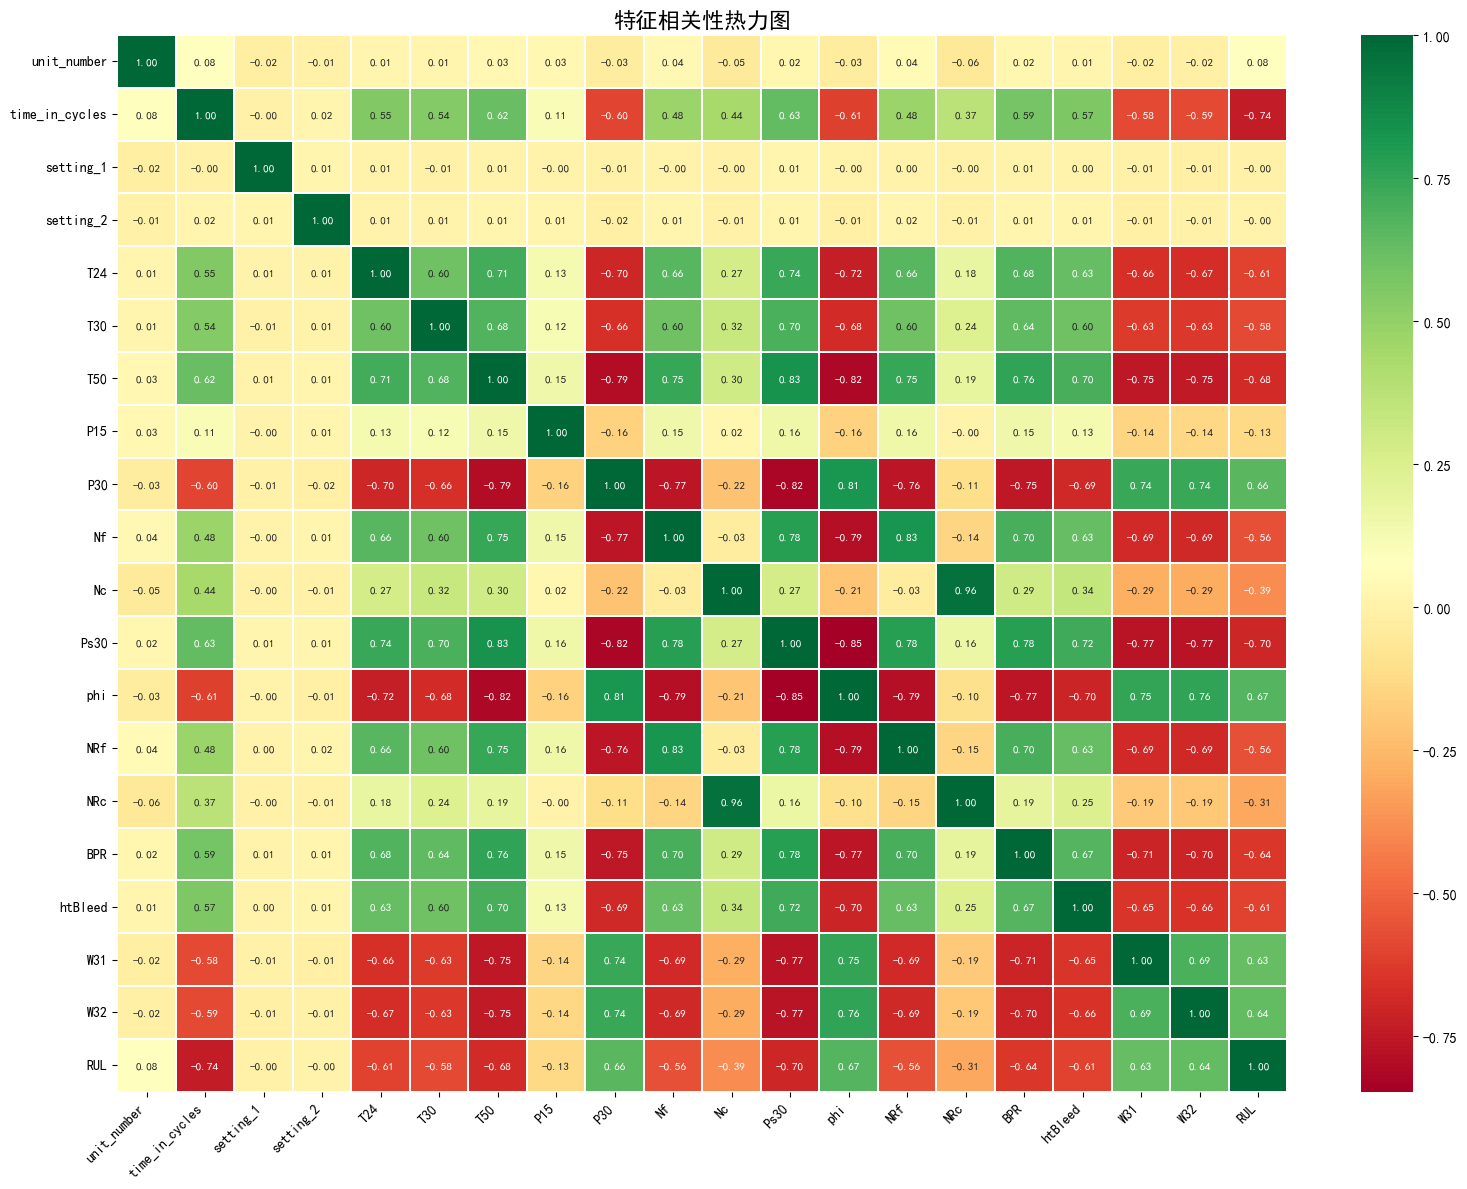

In [16]:
# 绘制特征相关性热力图
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, 
            annot=True, 
            cmap='RdYlGn', 
            linewidths=0.2,
            fmt='.2f',
            annot_kws={'size': 8})
plt.title('特征相关性热力图', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [17]:
# 找出与RUL相关性最高的特征
print("与RUL相关性最高的特征 (绝对值):")
rul_corr_abs = abs(correlation_matrix['RUL']).sort_values(ascending=False)
print(rul_corr_abs[1:11])  # 排除RUL自身

与RUL相关性最高的特征 (绝对值):
time_in_cycles    0.736241
Ps30              0.696228
T50               0.678948
phi               0.671983
P30               0.657223
BPR               0.642667
W32               0.635662
W31               0.629428
T24               0.606484
htBleed           0.606154
Name: RUL, dtype: float64


In [18]:
# 找出高度相关的特征对 (相关系数 > 0.8 或 < -0.8)
high_corr_pairs = []
threshold = 0.8

for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_value = correlation_matrix.iloc[i, j]
        if abs(corr_value) > threshold:
            high_corr_pairs.append({
                'feature1': correlation_matrix.columns[i],
                'feature2': correlation_matrix.columns[j],
                'correlation': corr_value
            })

print(f"高度相关的特征对 (阈值: {threshold}):")
for pair in high_corr_pairs:
    print(f"{pair['feature1']} <-> {pair['feature2']}: {pair['correlation']:.3f}")

print(f"\n总共找到 {len(high_corr_pairs)} 对高度相关的特征")

高度相关的特征对 (阈值: 0.8):
T50 <-> Ps30: 0.830
T50 <-> phi: -0.816
P30 <-> Ps30: -0.823
P30 <-> phi: 0.813
Nf <-> NRf: 0.826
Nc <-> NRc: 0.963
Ps30 <-> phi: -0.847

总共找到 7 对高度相关的特征


### 特征选择

基于相关性分析，我们将：
1. 删除与RUL弱相关的特征：setting_1, setting_2, P15, unit_number
2. 删除高度相关的特征之一：Nc和NRc的相关系数为0.96，删除NRc

In [19]:
# 计算特征相关性矩阵
print("正在计算特征相关性矩阵...")
correlation_matrix = df.corr()

print(f"相关性矩阵形状: {correlation_matrix.shape}")
print("\n与RUL的相关性:")
rul_correlation = correlation_matrix['RUL'].sort_values(ascending=False)
print(rul_correlation)

正在计算特征相关性矩阵...
相关性矩阵形状: (20, 20)

与RUL的相关性:
RUL               1.000000
phi               0.671983
P30               0.657223
W32               0.635662
W31               0.629428
unit_number       0.078753
setting_2        -0.001948
setting_1        -0.003198
P15              -0.128348
NRc              -0.306769
Nc               -0.390102
NRf              -0.562569
Nf               -0.563968
T30              -0.584520
htBleed          -0.606154
T24              -0.606484
BPR              -0.642667
T50              -0.678948
Ps30             -0.696228
time_in_cycles   -0.736241
Name: RUL, dtype: float64


In [20]:
# 注意：为了滑动窗口处理，我们需要保留unit_number和time_in_cycles列
# 只有在训练模型时才删除这些列
print(f"\n当前数据特征:")
print(f"训练数据特征数量: {len(df.columns)}")
print(f"训练数据特征: {df.columns.tolist()}")

print(f"\n测试数据特征数量: {len(fd_001_test.columns)}")
print(f"测试数据特征: {fd_001_test.columns.tolist()}")

# 创建用于滑动窗口的完整数据集（保留unit_number和time_in_cycles）
train_df_windows = df.copy()
test_df_windows = fd_001_test.copy()

print(f"\n滑动窗口数据集:")
print(f"训练数据特征数量: {len(train_df_windows.columns)}")
print(f"测试数据特征数量: {len(test_df_windows.columns)}")

# 为训练模型准备特征数据（删除不重要的特征）
features_to_drop = ['setting_1', 'setting_2', 'P15', 'NRc']  # 不删除unit_number和time_in_cycles
print(f"\n模型训练时删除的特征: {features_to_drop}")

print(f"删除前的特征数量: {len(df.columns)}")
train_df_model = df.drop(columns=features_to_drop)
print(f"删除后的特征数量: {len(train_df_model.columns)}")

print("\n最终保留的特征（用于模型训练）:")
print(train_df_model.columns.tolist())


当前数据特征:
训练数据特征数量: 20
训练数据特征: ['unit_number', 'time_in_cycles', 'setting_1', 'setting_2', 'T24', 'T30', 'T50', 'P15', 'P30', 'Nf', 'Nc', 'Ps30', 'phi', 'NRf', 'NRc', 'BPR', 'htBleed', 'W31', 'W32', 'RUL']

测试数据特征数量: 19
测试数据特征: ['unit_number', 'time_in_cycles', 'setting_1', 'setting_2', 'T24', 'T30', 'T50', 'P15', 'P30', 'Nf', 'Nc', 'Ps30', 'phi', 'NRf', 'NRc', 'BPR', 'htBleed', 'W31', 'W32']

滑动窗口数据集:
训练数据特征数量: 20
测试数据特征数量: 19

模型训练时删除的特征: ['setting_1', 'setting_2', 'P15', 'NRc']
删除前的特征数量: 20
删除后的特征数量: 16

最终保留的特征（用于模型训练）:
['unit_number', 'time_in_cycles', 'T24', 'T30', 'T50', 'P30', 'Nf', 'Nc', 'Ps30', 'phi', 'NRf', 'BPR', 'htBleed', 'W31', 'W32', 'RUL']


### 滑动窗口数据生成函数

In [21]:
def create_sliding_windows(data, window_size=50, step_size=1):
    """
    创建滑动窗口数据
    
    参数:
    - data: 包含发动机数据的DataFrame
    - window_size: 滑动窗口大小
    - step_size: 滑动步长
    
    返回:
    - sequences: 滑动窗口特征数组 (样本数, window_size * 特征数)
    - labels: 对应的RUL标签数组
    - metadata: 每个窗口的元数据 (unit_number, time_in_cycles, RUL, window_info)
    """
    print(f"开始创建滑动窗口数据...")
    print(f"窗口大小: {window_size}, 步长: {step_size}")
    
    # 检查数据中是否包含必要的列
    required_columns = ['unit_number', 'time_in_cycles', 'RUL']
    missing_columns = [col for col in required_columns if col not in data.columns]
    
    if missing_columns:
        print(f"错误：数据中缺少必要的列: {missing_columns}")
        print(f"可用列: {data.columns.tolist()}")
        raise ValueError(f"数据中缺少必要的列: {missing_columns}")
    
    # 获取特征列（排除元数据列和RUL列）
    feature_columns = [col for col in data.columns if col not in ['unit_number', 'time_in_cycles', 'RUL']]
    print(f"特征列: {feature_columns}")
    print(f"特征数量: {len(feature_columns)}")
    
    sequences = []
    labels = []
    metadata = []
    
    valid_engines = 0
    total_windows = 0
    
    print(f"数据中的发动机数量: {data['unit_number'].nunique()}")
    
    for unit_id in tqdm(data['unit_number'].unique(), desc="处理发动机"):
        # 获取单个发动机的数据并按时间排序
        unit_data = data[data['unit_number'] == unit_id].sort_values('time_in_cycles')
        
        # 检查是否有足够的数据创建窗口
        if len(unit_data) >= window_size:
            valid_engines += 1
            unit_windows = 0
            
            # 为该发动机创建滑动窗口
            for i in range(len(unit_data) - window_size + 1):
                # 提取窗口数据
                window_data = unit_data.iloc[i:i+window_size]
                
                # 获取特征值（排除元数据列）
                window_features = window_data[feature_columns].values
                
                # 展平窗口特征：window_size * n_features
                flattened_features = window_features.flatten()
                
                # 获取窗口结束时对应的RUL
                label = window_data.iloc[-1]['RUL']
                
                # 记录元数据
                unit_number = unit_id
                time_in_cycles = window_data.iloc[-1]['time_in_cycles']
                window_rul = label  # 将RUL也包含在元数据中
                
                sequences.append(flattened_features)
                labels.append(label)
                metadata.append({
                    'unit_number': unit_number,
                    'time_in_cycles': time_in_cycles,
                    'RUL': window_rul,  # 添加RUL到元数据
                    'window_start': i,
                    'window_end': i + window_size - 1
                })
                
                unit_windows += 1
                total_windows += 1
            
            if unit_id <= 5:  # 只显示前5个发动机的信息
                print(f"发动机 {unit_id}: {len(unit_data)} 个周期 -> {unit_windows} 个窗口")
    
    print(f"\n滑动窗口创建完成:")
    print(f"有效发动机数量: {valid_engines}/{data['unit_number'].nunique()}")
    print(f"总窗口数量: {total_windows}")
    print(f"特征维度: {len(feature_columns)} × {window_size} = {len(feature_columns) * window_size}")
    print(f"元数据列: {list(metadata[0].keys()) if metadata else '无元数据'}")
    
    return np.array(sequences), np.array(labels), pd.DataFrame(metadata)

print("滑动窗口数据生成函数定义完成！")

滑动窗口数据生成函数定义完成！


### 生成训练数据滑动窗口

In [22]:
# 为训练数据创建滑动窗口
print("=== 生成训练数据滑动窗口 ===")
X_train_windows, y_train_windows, train_metadata = create_sliding_windows(
    train_df_windows, window_size=WINDOW_SIZE, step_size=1
)

print(f"\n训练数据滑动窗口统计:")
print(f"特征数组形状: {X_train_windows.shape}")
print(f"标签数组形状: {y_train_windows.shape}")
print(f"元数据形状: {train_metadata.shape}")

# 显示窗口数据统计
print(f"\n窗口数据统计:")
print(f"特征最小值: {X_train_windows.min():.4f}")
print(f"特征最大值: {X_train_windows.max():.4f}")
print(f"特征均值: {X_train_windows.mean():.4f}")
print(f"特征标准差: {X_train_windows.std():.4f}")

print(f"\nRUL标签统计:")
print(f"最小RUL: {y_train_windows.min()}")
print(f"最大RUL: {y_train_windows.max()}")
print(f"平均RUL: {y_train_windows.mean():.1f}")
print(f"RUL标准差: {y_train_windows.std():.1f}")

=== 生成训练数据滑动窗口 ===
开始创建滑动窗口数据...
窗口大小: 50, 步长: 1
特征列: ['setting_1', 'setting_2', 'T24', 'T30', 'T50', 'P15', 'P30', 'Nf', 'Nc', 'Ps30', 'phi', 'NRf', 'NRc', 'BPR', 'htBleed', 'W31', 'W32']
特征数量: 17
数据中的发动机数量: 100


处理发动机:   0%|          | 0/100 [00:00<?, ?it/s]

发动机 1: 192 个周期 -> 143 个窗口


处理发动机:   2%|▏         | 2/100 [00:00<00:06, 14.05it/s]

发动机 2: 287 个周期 -> 238 个窗口
发动机 3: 179 个周期 -> 130 个窗口
发动机 4: 189 个周期 -> 140 个窗口
发动机 5: 269 个周期 -> 220 个窗口

处理发动机:   5%|▌         | 5/100 [00:00<00:06, 15.67it/s]

处理发动机: 100%|██████████| 100/100 [00:05<00:00, 16.84it/s]



滑动窗口创建完成:
有效发动机数量: 100/100
总窗口数量: 15731
特征维度: 17 × 50 = 850
元数据列: ['unit_number', 'time_in_cycles', 'RUL', 'window_start', 'window_end']

训练数据滑动窗口统计:
特征数组形状: (15731, 850)
标签数组形状: (15731,)
元数据形状: (15731, 5)

窗口数据统计:
特征最小值: -0.0087
特征最大值: 9244.5900
特征均值: 1601.7485
特征标准差: 2677.7120

RUL标签统计:
最小RUL: 0.0
最大RUL: 312.0
平均RUL: 84.9
RUL标准差: 57.4


In [23]:
# 查看滑动窗口数据示例
print("滑动窗口数据示例:")
print(f"\n前3个窗口的形状: {X_train_windows[:3].shape}")
print(f"前3个窗口的RUL标签: {y_train_windows[:3]}")

print("\n前5个窗口的元数据:")
display(train_metadata.head())

# 检查每个发动机的窗口数量
window_counts = train_metadata['unit_number'].value_counts().sort_index()
print(f"\n每个发动机的窗口数量（前10个）:")
print(window_counts.head(10))

print(f"\n窗口数量统计:")
print(f"平均每台发动机窗口数: {window_counts.mean():.1f}")
print(f"最少窗口数: {window_counts.min()}")
print(f"最多窗口数: {window_counts.max()}")

滑动窗口数据示例:

前3个窗口的形状: (3, 850)
前3个窗口的RUL标签: [142. 141. 140.]

前5个窗口的元数据:


,unit_number,time_in_cycles,RUL,window_start,window_end
0,1,50.0,142.0,0,49
1,1,51.0,141.0,1,50
2,1,52.0,140.0,2,51
3,1,53.0,139.0,3,52
4,1,54.0,138.0,4,53



每个发动机的窗口数量（前10个）:
unit_number
1     143
2     238
3     130
4     140
5     220
6     139
7     210
8     101
9     152
10    173
Name: count, dtype: int64

窗口数量统计:
平均每台发动机窗口数: 157.3
最少窗口数: 79
最多窗口数: 313


### 生成测试数据滑动窗口

In [24]:
# 为测试数据准备RUL信息
print("=== 准备测试数据RUL信息 ===")

# 首先检查test_df_windows是否已经创建
if 'test_df_windows' not in locals():
    print("创建test_df_windows...")
    # 创建用于滑动窗口的完整数据集（保留unit_number和time_in_cycles）
    test_df_windows = fd_001_test.copy()
    print(f"test_df_windows创建完成，形状: {test_df_windows.shape}")

# 加载真实RUL值
print("加载RUL文件...")
RUL_truth = pd.read_csv("./CMaps/RUL_FD001.txt", sep=" ", header=None)
print(f"原始RUL数据形状: {RUL_truth.shape}")
print("原始RUL数据前几行:")
display(RUL_truth.head())

# 检查是否有空列需要删除
print(f"\n检查RUL数据列:")
for i, col in enumerate(RUL_truth.columns):
    null_count = RUL_truth[col].isnull().sum()
    unique_count = RUL_truth[col].nunique()
    print(f"列 {i}: 空值数={null_count}, 唯一值数={unique_count}")

# 删除空列并设置正确的列名
if RUL_truth.shape[1] > 1:
    # 如果有多列，删除空列
    null_columns = [col for col in RUL_truth.columns if RUL_truth[col].isnull().all()]
    if null_columns:
        print(f"删除空列: {null_columns}")
        RUL_truth = RUL_truth.drop(columns=null_columns)
    
    # 只保留第一列作为RUL值
    if RUL_truth.shape[1] > 1:
        print(f"只保留第一列作为RUL值，删除其他列")
        RUL_truth = RUL_truth.iloc[:, [0]]

# 设置列名
RUL_truth.columns = ['RUL']
RUL_truth['unit_number'] = RUL_truth.index + 1

print(f"\n处理后的RUL数据形状: {RUL_truth.shape}")
print(f"处理后的RUL数据:")
display(RUL_truth.head())

print(f"\n测试数据形状: {test_df_windows.shape}")
print(f"测试数据列: {test_df_windows.columns.tolist()}")

# 为测试数据添加RUL信息
test_max = test_df_windows.groupby('unit_number')['time_in_cycles'].max().reset_index()
test_max.columns = ['unit_number', 'max_cycle']

print(f"\n测试数据最大周期信息:")
display(test_max.head())

# 合并真实RUL值
test_max = test_max.merge(RUL_truth, on='unit_number', how='left')
test_max['final_RUL'] = test_max['RUL']

print(f"\n合并真实RUL后的信息:")
display(test_max.head())

# 检查合并后的数据完整性
print(f"\n合并后数据检查:")
print(f"是否有缺失值: {test_max.isnull().sum().sum()}")
if test_max.isnull().sum().sum() > 0:
    print("缺失值统计:")
    print(test_max.isnull().sum())

# 计算每个时间点的RUL
test_with_rul = test_df_windows.merge(test_max[['unit_number', 'max_cycle', 'final_RUL']], on='unit_number', how='left')
test_with_rul['RUL'] = test_with_rul['final_RUL'] + (test_with_rul['max_cycle'] - test_with_rul['time_in_cycles'])

print(f"\n添加RUL后的测试数据形状: {test_with_rul.shape}")
print(f"测试数据列: {test_with_rul.columns.tolist()}")

# 显示测试数据RUL统计
print(f"\n测试数据RUL统计:")
print(f"最小RUL: {test_with_rul['RUL'].min()}")
print(f"最大RUL: {test_with_rul['RUL'].max()}")
print(f"平均RUL: {test_with_rul['RUL'].mean():.1f}")

# 验证数据完整性
print(f"\n数据完整性检查:")
print(f"测试数据中是否有缺失值: {test_with_rul.isnull().sum().sum()}")
if test_with_rul.isnull().sum().sum() > 0:
    print("缺失值详情:")
    missing_cols = test_with_rul.isnull().sum()
    print(missing_cols[missing_cols > 0])

print(f"测试数据中每台发动机的数据量:")
engine_counts = test_with_rul['unit_number'].value_counts().sort_index()
print(f"最少数据点: {engine_counts.min()}")
print(f"最多数据点: {engine_counts.max()}")
print(f"平均数据点: {engine_counts.mean():.1f}")

# 验证RUL计算是否正确
print(f"\nRUL计算验证（前5台发动机）:")
for unit_id in range(1, 6):
    unit_data = test_with_rul[test_with_rul['unit_number'] == unit_id].sort_values('time_in_cycles')
    if len(unit_data) > 0:
        last_cycle = unit_data['time_in_cycles'].max()
        predicted_rul = unit_data[unit_data['time_in_cycles'] == last_cycle]['RUL'].iloc[0]
        true_rul = RUL_truth[RUL_truth['unit_number'] == unit_id]['RUL'].iloc[0]
        print(f"发动机{unit_id}: 最后一周期={last_cycle}, 预测RUL={predicted_rul}, 真实RUL={true_rul}")

=== 准备测试数据RUL信息 ===
加载RUL文件...
原始RUL数据形状: (100, 2)
原始RUL数据前几行:


,0,1
0,112,NaN
1,98,NaN
2,69,NaN
3,82,NaN
4,91,NaN



检查RUL数据列:
列 0: 空值数=0, 唯一值数=71
列 1: 空值数=100, 唯一值数=0
删除空列: [1]

处理后的RUL数据形状: (100, 2)
处理后的RUL数据:


,RUL,unit_number
0,112,1
1,98,2
2,69,3
3,82,4
4,91,5



测试数据形状: (13096, 19)
测试数据列: ['unit_number', 'time_in_cycles', 'setting_1', 'setting_2', 'T24', 'T30', 'T50', 'P15', 'P30', 'Nf', 'Nc', 'Ps30', 'phi', 'NRf', 'NRc', 'BPR', 'htBleed', 'W31', 'W32']

测试数据最大周期信息:


,unit_number,max_cycle
0,1,31
1,2,49
2,3,126
3,4,106
4,5,98



合并真实RUL后的信息:


,unit_number,max_cycle,RUL,final_RUL
0,1,31,112,112
1,2,49,98,98
2,3,126,69,69
3,4,106,82,82
4,5,98,91,91



合并后数据检查:
是否有缺失值: 0

添加RUL后的测试数据形状: (13096, 22)
测试数据列: ['unit_number', 'time_in_cycles', 'setting_1', 'setting_2', 'T24', 'T30', 'T50', 'P15', 'P30', 'Nf', 'Nc', 'Ps30', 'phi', 'NRf', 'NRc', 'BPR', 'htBleed', 'W31', 'W32', 'max_cycle', 'final_RUL', 'RUL']

测试数据RUL统计:
最小RUL: 7
最大RUL: 340
平均RUL: 141.2

数据完整性检查:
测试数据中是否有缺失值: 0
测试数据中每台发动机的数据量:
最少数据点: 31
最多数据点: 303
平均数据点: 131.0

RUL计算验证（前5台发动机）:
发动机1: 最后一周期=31, 预测RUL=112, 真实RUL=112
发动机2: 最后一周期=49, 预测RUL=98, 真实RUL=98
发动机3: 最后一周期=126, 预测RUL=69, 真实RUL=69
发动机4: 最后一周期=106, 预测RUL=82, 真实RUL=82
发动机5: 最后一周期=98, 预测RUL=91, 真实RUL=91


In [25]:
# 为测试数据创建滑动窗口
print("\n=== 生成测试数据滑动窗口 ===")

# 验证test_with_rul数据
print(f"test_with_rul数据验证:")
print(f"形状: {test_with_rul.shape}")
print(f"列: {test_with_rul.columns.tolist()}")
print(f"是否包含RUL列: {'RUL' in test_with_rul.columns}")
print(f"是否包含unit_number列: {'unit_number' in test_with_rul.columns}")
print(f"是否包含time_in_cycles列: {'time_in_cycles' in test_with_rul.columns}")

# 检查数据完整性
print(f"\n数据完整性检查:")
print(f"缺失值统计:")
missing_values = test_with_rul.isnull().sum()
print(missing_values[missing_values > 0] if missing_values.sum() > 0 else "无缺失值")

# 检查滑动窗口的适用性
test_cycles_count = test_with_rul.groupby('unit_number')['time_in_cycles'].count()
engines_with_enough_data = (test_cycles_count >= WINDOW_SIZE).sum()
total_engines = len(test_cycles_count)

print(f"\n滑动窗口适用性检查:")
print(f"窗口大小: {WINDOW_SIZE}")
print(f"总发动机数: {total_engines}")
print(f"数据点足够({WINDOW_SIZE}+)的发动机: {engines_with_enough_data}")
print(f"适用性比例: {engines_with_enough_data/total_engines*100:.1f}%")

if engines_with_enough_data < total_engines:
    print(f"\n数据点不足的发动机:")
    insufficient_engines = test_cycles_count[test_cycles_count < WINDOW_SIZE]
    print(insufficient_engines.head(10))
    
    # 只对数据充足的发动机创建滑动窗口
    valid_engines = test_cycles_count[test_cycles_count >= WINDOW_SIZE].index.tolist()
    print(f"\n只对以下{len(valid_engines)}台发动机创建滑动窗口:")
    print(f"有效发动机: {valid_engines[:10]}{'...' if len(valid_engines) > 10 else ''}")
    
    # 过滤数据
    test_with_rul_filtered = test_with_rul[test_with_rul['unit_number'].isin(valid_engines)].copy()
    print(f"过滤后的测试数据形状: {test_with_rul_filtered.shape}")
else:
    test_with_rul_filtered = test_with_rul.copy()
    print("所有发动机都有足够的数据点，无需过滤")

# 创建滑动窗口
X_test_windows, y_test_windows, test_metadata = create_sliding_windows(
    test_with_rul_filtered, window_size=WINDOW_SIZE, step_size=1
)

print(f"\n测试数据滑动窗口统计:")
print(f"特征数组形状: {X_test_windows.shape}")
print(f"标签数组形状: {y_test_windows.shape}")
print(f"元数据形状: {test_metadata.shape}")

# 检查每个发动机的窗口数量
test_window_counts = test_metadata['unit_number'].value_counts().sort_index()
print(f"\n测试数据每个发动机的窗口数量（前10个）:")
print(test_window_counts.head(10))

print(f"\n测试数据窗口数量统计:")
print(f"平均每台发动机窗口数: {test_window_counts.mean():.1f}")
print(f"最少窗口数: {test_window_counts.min()}")
print(f"最多窗口数: {test_window_counts.max()}")

# 检查窗口数据质量
print(f"\n窗口数据质量检查:")
print(f"特征数组是否包含NaN: {np.isnan(X_test_windows).any()}")
print(f"标签数组是否包含NaN: {np.isnan(y_test_windows).any()}")
print(f"特征数组是否包含无穷大: {np.isinf(X_test_windows).any()}")
print(f"标签数组是否包含无穷大: {np.isinf(y_test_windows).any()}")

if np.isnan(X_test_windows).any() or np.isnan(y_test_windows).any():
    print("⚠️  检测到NaN值，这可能影响模型训练！")
    
if np.isinf(X_test_windows).any() or np.isinf(y_test_windows).any():
    print("⚠️  检测到无穷大值，这可能影响模型训练！")

print("✅ 测试数据滑动窗口创建完成！")


=== 生成测试数据滑动窗口 ===
test_with_rul数据验证:
形状: (13096, 22)
列: ['unit_number', 'time_in_cycles', 'setting_1', 'setting_2', 'T24', 'T30', 'T50', 'P15', 'P30', 'Nf', 'Nc', 'Ps30', 'phi', 'NRf', 'NRc', 'BPR', 'htBleed', 'W31', 'W32', 'max_cycle', 'final_RUL', 'RUL']
是否包含RUL列: True
是否包含unit_number列: True
是否包含time_in_cycles列: True

数据完整性检查:
缺失值统计:
无缺失值

滑动窗口适用性检查:
窗口大小: 50
总发动机数: 100
数据点足够(50+)的发动机: 93
适用性比例: 93.0%

数据点不足的发动机:
unit_number
1     31
2     49
14    46
22    39
25    48
39    37
85    34
Name: time_in_cycles, dtype: int64

只对以下93台发动机创建滑动窗口:
有效发动机: [3, 4, 5, 6, 7, 8, 9, 10, 11, 12]...
过滤后的测试数据形状: (12812, 22)
开始创建滑动窗口数据...
窗口大小: 50, 步长: 1
特征列: ['setting_1', 'setting_2', 'T24', 'T30', 'T50', 'P15', 'P30', 'Nf', 'Nc', 'Ps30', 'phi', 'NRf', 'NRc', 'BPR', 'htBleed', 'W31', 'W32', 'max_cycle', 'final_RUL']
特征数量: 19
数据中的发动机数量: 93


处理发动机:   0%|          | 0/93 [00:00<?, ?it/s]

发动机 3: 126 个周期 -> 77 个窗口
发动机 4: 106 个周期 -> 57 个窗口
发动机 5: 98 个周期 -> 49 个窗口


处理发动机: 100%|██████████| 93/93 [00:03<00:00, 30.55it/s]


滑动窗口创建完成:
有效发动机数量: 93/93
总窗口数量: 8255
特征维度: 19 × 50 = 950
元数据列: ['unit_number', 'time_in_cycles', 'RUL', 'window_start', 'window_end']

测试数据滑动窗口统计:
特征数组形状: (8255, 950)
标签数组形状: (8255,)
元数据形状: (8255, 5)

测试数据每个发动机的窗口数量（前10个）:
unit_number
3      77
4      57
5      49
6      56
7     111
8     117
9       6
10    143
11     34
12    168
Name: count, dtype: int64

测试数据窗口数量统计:
平均每台发动机窗口数: 88.8
最少窗口数: 1
最多窗口数: 254

窗口数据质量检查:
特征数组是否包含NaN: False
标签数组是否包含NaN: False
特征数组是否包含无穷大: False
标签数组是否包含无穷大: False
✅ 测试数据滑动窗口创建完成！


### 滑动窗口数据可视化

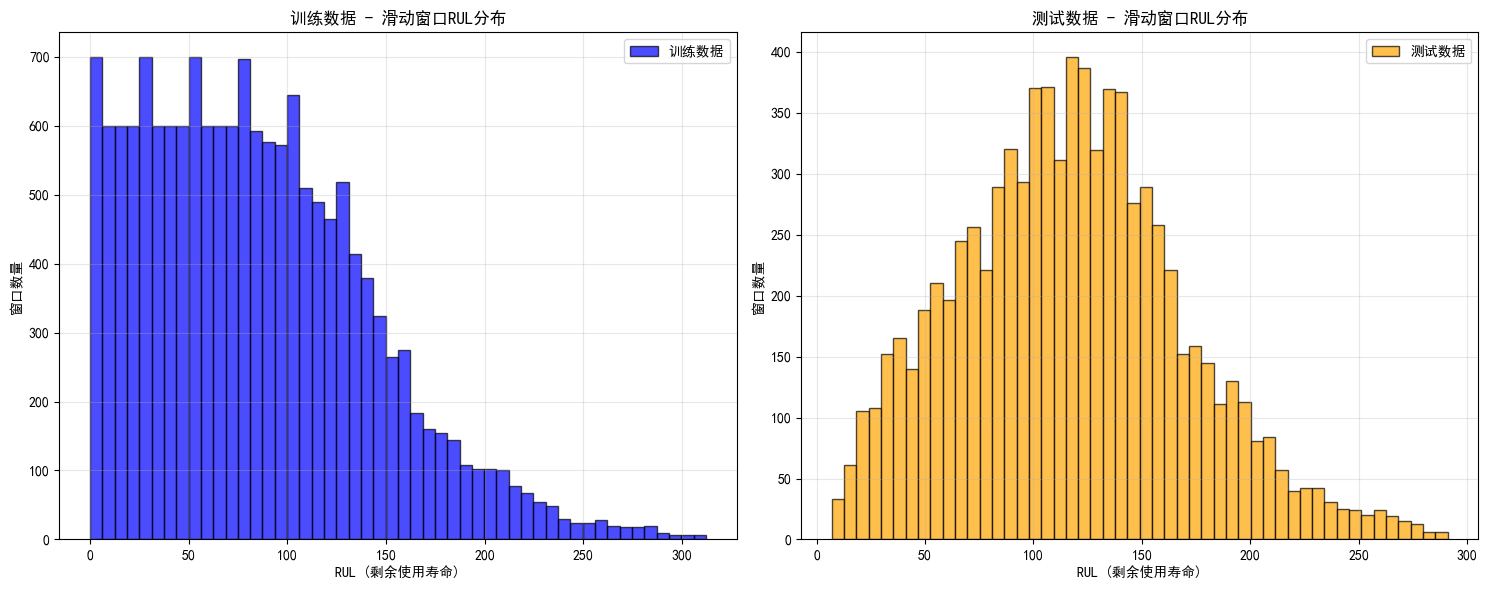

滑动窗口RUL分布对比:
训练数据窗口数: 15731
测试数据窗口数: 8255
训练数据RUL均值: 84.9
测试数据RUL均值: 117.1


In [26]:
# 可视化滑动窗口RUL分布
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# 训练数据RUL分布
ax1.hist(y_train_windows, bins=50, alpha=0.7, color='blue', edgecolor='black', label='训练数据')
ax1.set_title('训练数据 - 滑动窗口RUL分布')
ax1.set_xlabel('RUL (剩余使用寿命)')
ax1.set_ylabel('窗口数量')
ax1.grid(True, alpha=0.3)
ax1.legend()

# 测试数据RUL分布
ax2.hist(y_test_windows, bins=50, alpha=0.7, color='orange', edgecolor='black', label='测试数据')
ax2.set_title('测试数据 - 滑动窗口RUL分布')
ax2.set_xlabel('RUL (剩余使用寿命)')
ax2.set_ylabel('窗口数量')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

print(f"滑动窗口RUL分布对比:")
print(f"训练数据窗口数: {len(y_train_windows)}")
print(f"测试数据窗口数: {len(y_test_windows)}")
print(f"训练数据RUL均值: {y_train_windows.mean():.1f}")
print(f"测试数据RUL均值: {y_test_windows.mean():.1f}")

=== 滑动窗口可视化示例 ===
测试数据中的发动机: [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
测试数据中的发动机数量: 93
选择的可视化发动机: [3, 4, 5]

可视化发动机 3...
发动机 3 数据检查:
  发动机数据形状: (126, 22)
  发动机数据列: ['unit_number', 'time_in_cycles', 'setting_1', 'setting_2', 'T24', 'T30', 'T50', 'P15', 'P30', 'Nf', 'Nc', 'Ps30', 'phi', 'NRf', 'NRc', 'BPR', 'htBleed', 'W31', 'W32', 'max_cycle', 'final_RUL', 'RUL']
  窗口数据形状: (77, 5)
  窗口数据列: ['unit_number', 'time_in_cycles', 'RUL', 'window_start', 'window_end']


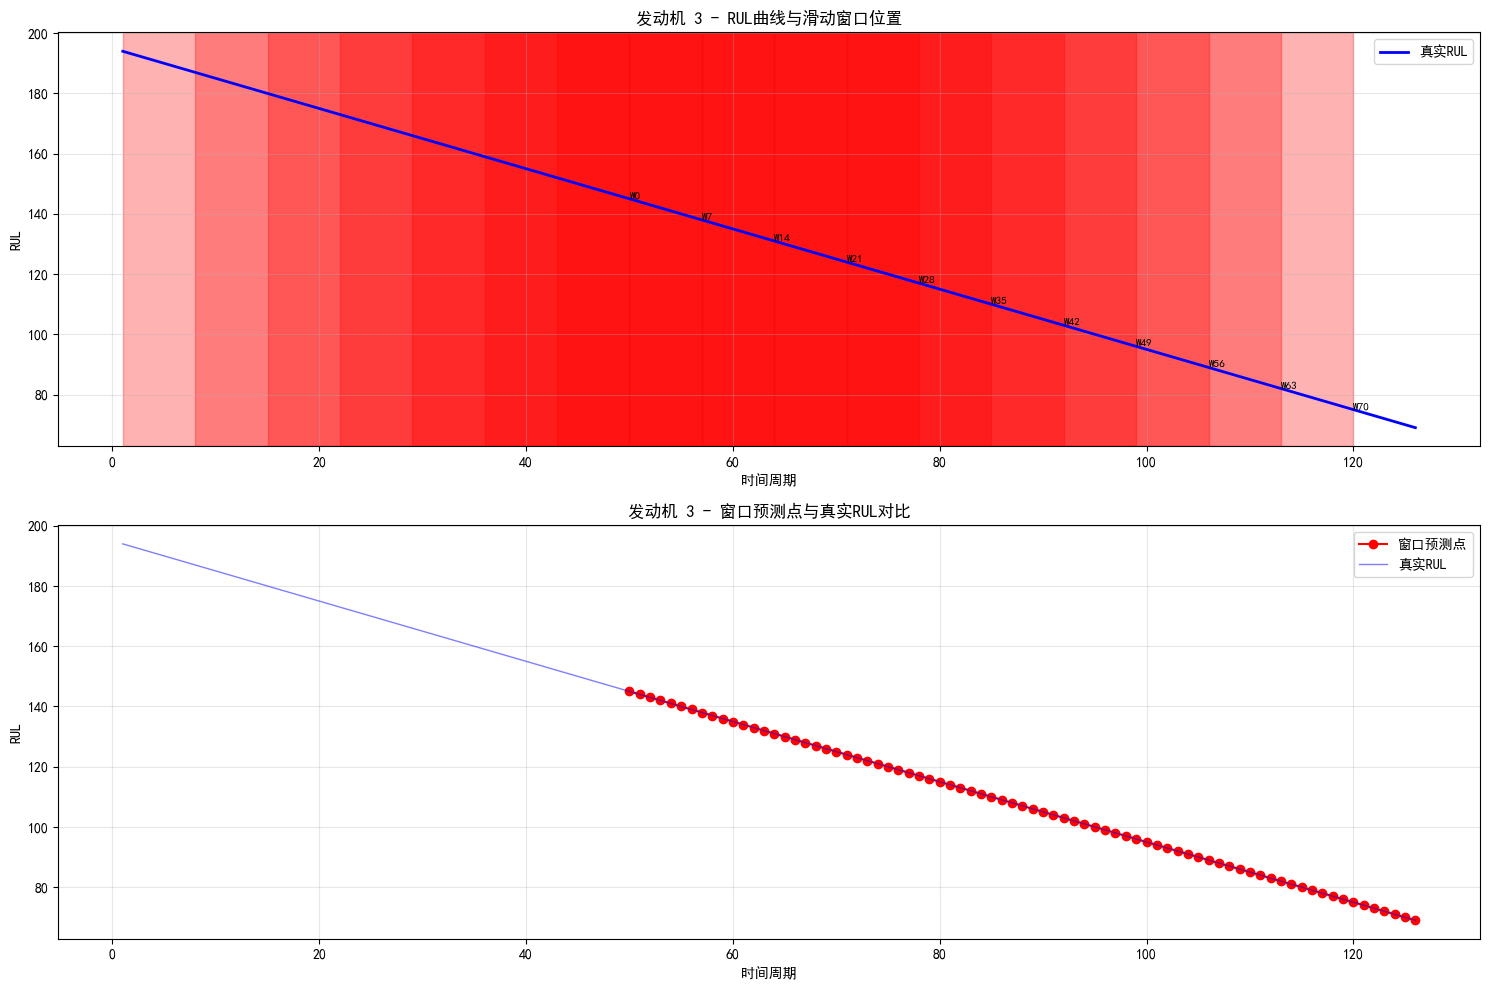

发动机 3:
  总周期数: 126
  窗口数量: 77
  窗口覆盖率: 61.1%

可视化发动机 4...
发动机 4 数据检查:
  发动机数据形状: (106, 22)
  发动机数据列: ['unit_number', 'time_in_cycles', 'setting_1', 'setting_2', 'T24', 'T30', 'T50', 'P15', 'P30', 'Nf', 'Nc', 'Ps30', 'phi', 'NRf', 'NRc', 'BPR', 'htBleed', 'W31', 'W32', 'max_cycle', 'final_RUL', 'RUL']
  窗口数据形状: (57, 5)
  窗口数据列: ['unit_number', 'time_in_cycles', 'RUL', 'window_start', 'window_end']


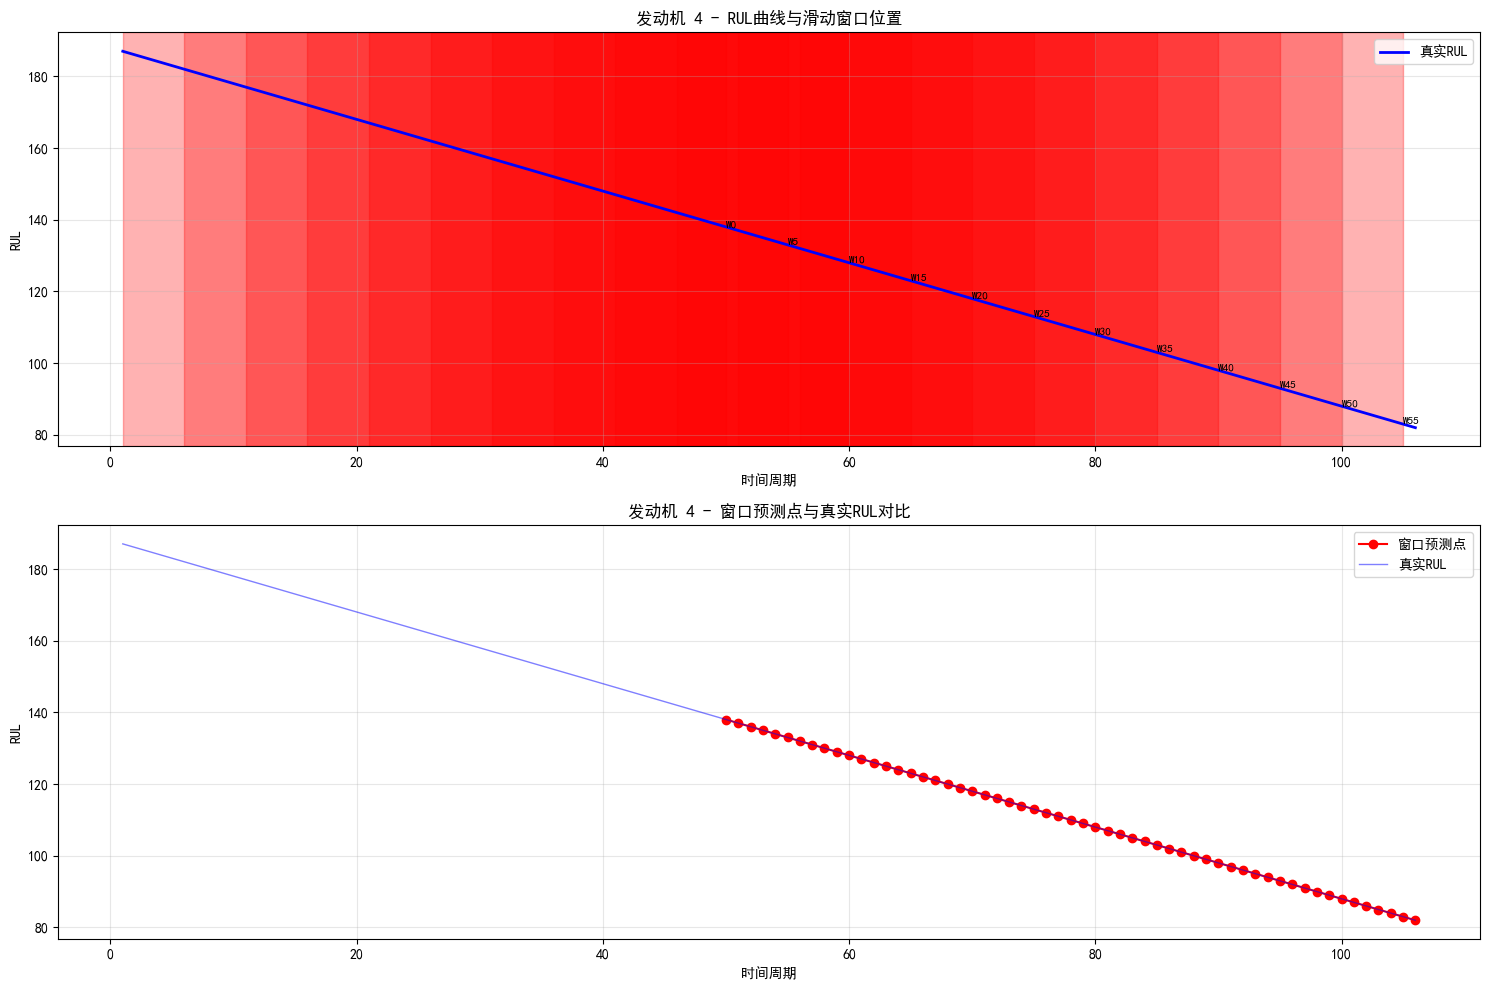

发动机 4:
  总周期数: 106
  窗口数量: 57
  窗口覆盖率: 53.8%

可视化发动机 5...
发动机 5 数据检查:
  发动机数据形状: (98, 22)
  发动机数据列: ['unit_number', 'time_in_cycles', 'setting_1', 'setting_2', 'T24', 'T30', 'T50', 'P15', 'P30', 'Nf', 'Nc', 'Ps30', 'phi', 'NRf', 'NRc', 'BPR', 'htBleed', 'W31', 'W32', 'max_cycle', 'final_RUL', 'RUL']
  窗口数据形状: (49, 5)
  窗口数据列: ['unit_number', 'time_in_cycles', 'RUL', 'window_start', 'window_end']


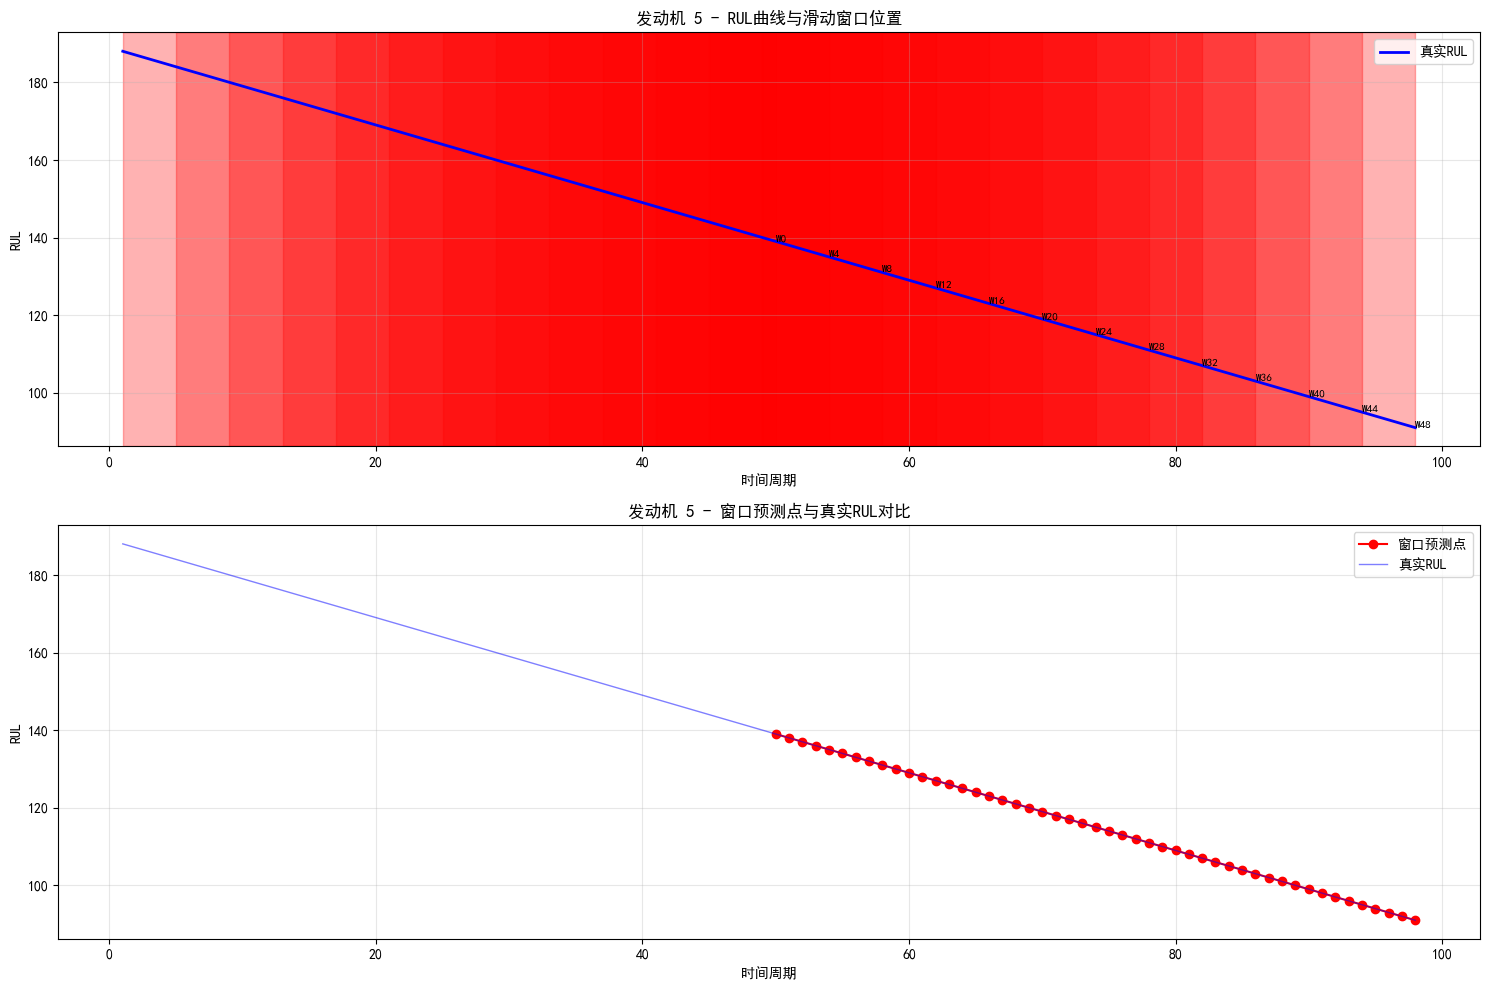

发动机 5:
  总周期数: 98
  窗口数量: 49
  窗口覆盖率: 50.0%


In [27]:
# 可视化单个发动机的滑动窗口示例
def visualize_single_engine_windows(engine_id, data, metadata, window_size=50):
    """
    可视化单个发动机的滑动窗口
    """
    # 获取该发动机的窗口
    engine_windows = metadata[metadata['unit_number'] == engine_id]
    
    if len(engine_windows) == 0:
        print(f"发动机 {engine_id} 没有有效的滑动窗口")
        return
    
    # 获取发动机原始数据
    engine_data = data[data['unit_number'] == engine_id].sort_values('time_in_cycles')
    
    print(f"发动机 {engine_id} 数据检查:")
    print(f"  发动机数据形状: {engine_data.shape}")
    print(f"  发动机数据列: {engine_data.columns.tolist()}")
    print(f"  窗口数据形状: {engine_windows.shape}")
    print(f"  窗口数据列: {engine_windows.columns.tolist()}")
    
    # 检查数据中是否包含RUL列
    if 'RUL' not in engine_data.columns:
        print(f"错误：发动机数据中缺少RUL列")
        return
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    
    # 上图：原始RUL曲线和窗口位置
    ax1.plot(engine_data['time_in_cycles'], engine_data['RUL'], 'b-', linewidth=2, label='真实RUL')
    
    # 标记窗口位置
    for i, (_, window) in enumerate(engine_windows.iterrows()):
        if i % max(1, len(engine_windows) // 10) == 0:  # 只显示部分窗口避免过于拥挤
            start_cycle = window['window_start'] + 1
            end_cycle = window['window_end'] + 1
            
            # 从窗口元数据中获取RUL值，如果有的话
            window_rul = window.get('RUL', None)
            if window_rul is not None:
                ax1.text(end_cycle, window_rul, f'W{i}', fontsize=8)
            else:
                # 如果元数据中没有RUL，从原始数据中获取对应时间点的RUL
                rul_at_time = engine_data[engine_data['time_in_cycles'] == window['time_in_cycles']]['RUL']
                if len(rul_at_time) > 0:
                    ax1.text(end_cycle, rul_at_time.iloc[0], f'W{i}', fontsize=8)
            
            ax1.axvspan(start_cycle, end_cycle, alpha=0.3, color='red')
    
    ax1.set_xlabel('时间周期')
    ax1.set_ylabel('RUL')
    ax1.set_title(f'发动机 {engine_id} - RUL曲线与滑动窗口位置')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 下图：窗口预测点与真实值对比
    window_times = engine_windows['time_in_cycles'].values
    
    # 从窗口元数据获取RUL值，如果有的话
    if 'RUL' in engine_windows.columns:
        window_ruls = engine_windows['RUL'].values
    else:
        # 如果元数据中没有RUL，从原始数据中获取对应时间点的RUL
        window_ruls = []
        for time_cycle in window_times:
            rul_at_time = engine_data[engine_data['time_in_cycles'] == time_cycle]['RUL']
            if len(rul_at_time) > 0:
                window_ruls.append(rul_at_time.iloc[0])
            else:
                window_ruls.append(np.nan)
        window_ruls = np.array(window_ruls)
    
    ax2.plot(window_times, window_ruls, 'ro-', label='窗口预测点', markersize=6)
    ax2.plot(engine_data['time_in_cycles'], engine_data['RUL'], 'b-', alpha=0.5, label='真实RUL', linewidth=1)
    ax2.set_xlabel('时间周期')
    ax2.set_ylabel('RUL')
    ax2.set_title(f'发动机 {engine_id} - 窗口预测点与真实RUL对比')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"发动机 {engine_id}:")
    print(f"  总周期数: {len(engine_data)}")
    print(f"  窗口数量: {len(engine_windows)}")
    print(f"  窗口覆盖率: {len(engine_windows)/len(engine_data)*100:.1f}%")
    
    return

# 可视化几个示例发动机
print("=== 滑动窗口可视化示例 ===")

# 首先检查可用的发动机
print(f"测试数据中的发动机: {sorted(test_metadata['unit_number'].unique())}")
print(f"测试数据中的发动机数量: {test_metadata['unit_number'].nunique()}")

# 选择示例发动机
available_engines = sorted(test_metadata['unit_number'].unique())
sample_engines = available_engines[:3] if len(available_engines) >= 3 else available_engines

print(f"选择的可视化发动机: {sample_engines}")

for engine_id in sample_engines:
    try:
        print(f"\n可视化发动机 {engine_id}...")
        visualize_single_engine_windows(engine_id, test_with_rul, test_metadata, WINDOW_SIZE)
    except Exception as e:
        print(f"可视化发动机 {engine_id} 时出错: {str(e)}")
        print("跳过该发动机的可视化")

## 3. XGBoost回归模型训练

### 评估指标定义

In [28]:
# 竞赛数据的误差函数
def score(y_true, y_pred, a1=10, a2=13):
    """
    竞赛的评分函数
    
    参数:
    - y_true: 真实值
    - y_pred: 预测值
    - a1: 提前预测的惩罚参数 (默认10)
    - a2: 延迟预测的惩罚参数 (默认13)
    """
    score = 0
    d = y_pred - y_true
    for i in d:
        if i >= 0:
            score += math.exp(i/a2) - 1   
        else:
            score += math.exp(- i/a1) - 1
    return score

# 评估函数：计算多个指标
def score_func(y_true, y_pred):
    """
    计算并显示多个评估指标
    """
    lst = [round(score(y_true, y_pred), 2), 
          round(mean_absolute_error(y_true, y_pred), 2),
          round(mean_squared_error(y_true, y_pred), 2)**0.5,
          round(r2_score(y_true, y_pred), 2)]
    
    print(f'竞赛评分: {lst[0]}')
    print(f'平均绝对误差 (MAE): {lst[1]}')
    print(f'均方根误差 (RMSE): {lst[2]}')
    print(f'R²分数: {lst[3]}')
    return [lst[1], round(lst[2], 2), lst[3]*100]

print("评估函数定义完成！")

评估函数定义完成！


### XGBoost模型训练函数

In [29]:
# 创建和训练XGBoost回归模型的函数
def train_xgboost_model(X_train, y_train, X_test, y_test, 
                       n_estimators=200, learning_rate=0.1, max_depth=6):
    """
    训练XGBoost回归模型
    
    参数:
    - X_train: 训练特征
    - y_train: 训练标签
    - X_test: 测试特征
    - y_test: 测试标签
    - n_estimators: 树的数量
    - learning_rate: 学习率
    - max_depth: 树的最大深度
    
    返回:
    - 训练好的XGBoost模型
    """
    print(f"=== XGBoost模型训练参数 ===")
    print(f"特征矩阵形状: {X_train.shape}")
    print(f"目标向量形状: {y_train.shape}")
    print(f"特征维度: {X_train.shape[1]} ({X_train.shape[1]//WINDOW_SIZE}特征 × {WINDOW_SIZE}时间窗口)")
    print(f"训练样本数: {X_train.shape[0]}")
    print(f"测试样本数: {X_test.shape[0]}")
    print(f"\n模型参数:")
    print(f"  n_estimators: {n_estimators}")
    print(f"  learning_rate: {learning_rate}")
    print(f"  max_depth: {max_depth}")
    
    # XGBoost回归器 - 使用更适合时间序列的参数
    model = xgboost.XGBRegressor(
        n_estimators=n_estimators, 
        learning_rate=learning_rate, 
        max_depth=max_depth,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        reg_alpha=0.1,  # L1正则化
        reg_lambda=1.0  # L2正则化
    )
    
    print("\n开始训练XGBoost模型...")
    start_time = time.time()
    
    # 方法1：尝试使用eval_set参数（适用于较新版本）
    try:
        print("尝试使用eval_set参数进行训练...")
        model.fit(X_train, y_train,
                  eval_set=[(X_test, y_test)],
                  verbose=False)
        print("✅ 使用eval_set参数训练成功")
    except TypeError as e:
        print(f"❌ eval_set参数不可用: {str(e)}")
        print("尝试不使用验证集进行训练...")
        # 方法2：不使用验证集
        model.fit(X_train, y_train)
        print("✅ 不使用验证集训练成功")
    
    training_time = time.time() - start_time
    print(f"模型训练完成！训练时间: {training_time:.2f}秒")
    
    return model

print("XGBoost训练函数定义完成！")

XGBoost训练函数定义完成！


### 数据分割与模型训练

In [30]:
# 分割训练和测试数据
print("=== 数据分割与维度检查 ===")

# 首先检查训练数据和测试数据的特征维度
print(f"训练数据特征维度: {X_train_windows.shape}")
print(f"测试数据特征维度: {X_test_windows.shape}")

print(f"\n训练数据标签维度: {y_train_windows.shape}")
print(f"测试数据标签维度: {y_test_windows.shape}")

# 检查特征列是否一致
print(f"\n特征维度检查:")
print(f"训练特征数: {X_train_windows.shape[1]}")
print(f"测试特征数: {X_test_windows.shape[1]}")

if X_train_windows.shape[1] != X_test_windows.shape[1]:
    print(f"❌ 特征维度不匹配！")
    print(f"训练数据: {X_train_windows.shape[1]} 特征")
    print(f"测试数据: {X_test_windows.shape[1]} 特征")
    print(f"差异: {X_test_windows.shape[1] - X_train_windows.shape[1]} 特征")
    
    # 计算预期特征数
    expected_train_features = X_train_windows.shape[1] // WINDOW_SIZE
    expected_test_features = X_test_windows.shape[1] // WINDOW_SIZE
    
    print(f"\n预期特征数计算:")
    print(f"训练数据: {X_train_windows.shape[1]} ÷ {WINDOW_SIZE} = {expected_train_features} 特征")
    print(f"测试数据: {X_test_windows.shape[1]} ÷ {WINDOW_SIZE} = {expected_test_features} 特征")
    
    # 检查元数据中包含的特征数量
    print(f"\n元数据检查:")
    print(f"训练元数据列: {train_metadata.columns.tolist()}")
    print(f"测试元数据列: {test_metadata.columns.tolist()}")
    
    # 检查原始数据中的特征列
    print(f"\n原始数据特征列检查:")
    train_feature_cols = [col for col in train_df_windows.columns if col not in ['unit_number', 'time_in_cycles', 'RUL']]
    test_feature_cols = [col for col in test_df_windows.columns if col not in ['unit_number', 'time_in_cycles', 'RUL']]
    
    print(f"训练数据特征列: {train_feature_cols}")
    print(f"测试数据特征列: {test_feature_cols}")
    print(f"训练特征数量: {len(train_feature_cols)}")
    print(f"测试特征数量: {len(test_feature_cols)}")
    
    # 如果特征列不同，统一特征列
    if train_feature_cols != test_feature_cols:
        print(f"\n❌ 特征列不一致！")
        common_features = list(set(train_feature_cols) & set(test_feature_cols))
        print(f"共同特征: {common_features}")
        print(f"仅在训练数据中的特征: {list(set(train_feature_cols) - set(test_feature_cols))}")
        print(f"仅在测试数据中的特征: {list(set(test_feature_cols) - set(train_feature_cols))}")
        
        # 使用共同特征重新创建滑动窗口
        print(f"\n使用共同特征重新创建滑动窗口...")
        common_feature_cols = sorted(common_features)
        print(f"使用的共同特征 ({len(common_feature_cols)}): {common_feature_cols}")
        print(f"预期特征维度: {len(common_feature_cols)} × {WINDOW_SIZE} = {len(common_feature_cols) * WINDOW_SIZE}")
        
        # 重新创建训练数据滑动窗口（只使用共同特征）
        print("重新创建训练数据滑动窗口...")
        train_df_common = train_df_windows[['unit_number', 'time_in_cycles', 'RUL'] + common_feature_cols]
        X_train_windows, y_train_windows, train_metadata = create_sliding_windows(
            train_df_common, window_size=WINDOW_SIZE, step_size=1
        )
        
        # 重新创建测试数据滑动窗口（只使用共同特征）
        print("重新创建测试数据滑动窗口...")
        test_df_common = test_with_rul[['unit_number', 'time_in_cycles', 'RUL'] + common_feature_cols]
        X_test_windows, y_test_windows, test_metadata = create_sliding_windows(
            test_df_common, window_size=WINDOW_SIZE, step_size=1
        )
        
        print(f"\n重新创建后的数据维度:")
        print(f"训练数据: {X_train_windows.shape}")
        print(f"测试数据: {X_test_windows.shape}")
        
        if X_train_windows.shape[1] == X_test_windows.shape[1]:
            print("✅ 特征维度已统一！")
        else:
            print(f"❌ 仍然不匹配，训练: {X_train_windows.shape[1]}, 测试: {X_test_windows.shape[1]}")
    else:
        print("✅ 特征列一致，但维度仍然不匹配，检查滑动窗口创建过程...")
        print(f"问题可能是：训练数据使用了{expected_train_features}个特征，测试数据使用了{expected_test_features}个特征")
        print(f"需要统一使用相同的特征列和滑动窗口创建参数")
        
        # 即使特征列名称相同，也要确保数量一致
        # 统一使用训练数据的特征列
        print(f"\n统一使用训练数据的特征列重新创建测试数据滑动窗口...")
        print(f"使用特征: {train_feature_cols}")
        print(f"预期特征维度: {len(train_feature_cols)} × {WINDOW_SIZE} = {len(train_feature_cols) * WINDOW_SIZE}")
        
        # 重新创建测试数据滑动窗口（使用训练数据的特征列）
        test_df_common = test_with_rul[['unit_number', 'time_in_cycles', 'RUL'] + train_feature_cols]
        X_test_windows, y_test_windows, test_metadata = create_sliding_windows(
            test_df_common, window_size=WINDOW_SIZE, step_size=1
        )
        
        print(f"\n重新创建后的测试数据维度:")
        print(f"测试数据: {X_test_windows.shape}")
        
        if X_train_windows.shape[1] == X_test_windows.shape[1]:
            print("✅ 特征维度已统一！")
        else:
            print(f"❌ 仍然不匹配，训练: {X_train_windows.shape[1]}, 测试: {X_test_windows.shape[1]}")
            print(f"需要进一步调试滑动窗口创建过程")
else:
    print("✅ 特征维度匹配！")

# 按时间序列顺序分割，使用最后的部分作为测试集
split_ratio = 0.8
split_index = int(len(X_train_windows) * split_ratio)

X_train_split = X_train_windows[:split_index]
y_train_split = y_train_windows[:split_index]
X_val_split = X_train_windows[split_index:]
y_val_split = y_train_windows[split_index:]

print(f"\n数据分割结果:")
print(f"训练集大小: {X_train_split.shape[0]}")
print(f"验证集大小: {X_val_split.shape[0]}")
print(f"测试集大小: {X_test_windows.shape[0]}")
print(f"分割比例: {split_ratio}:{1-split_ratio}")

print(f"\n数据集RUL分布:")
print(f"训练集RUL均值: {y_train_split.mean():.1f}")
print(f"验证集RUL均值: {y_val_split.mean():.1f}")
print(f"测试集RUL均值: {y_test_windows.mean():.1f}")

# 最终验证
print(f"\n最终维度验证:")
print(f"训练特征: {X_train_split.shape}")
print(f"验证特征: {X_val_split.shape}")
print(f"测试特征: {X_test_windows.shape}")
print(f"所有特征维度一致: {X_train_split.shape[1] == X_val_split.shape[1] == X_test_windows.shape[1]}")

# 如果维度仍然不匹配，提供解决方案建议
if X_train_split.shape[1] != X_test_windows.shape[1]:
    print(f"\n⚠️  维度仍然不匹配，可能的原因：")
    print(f"1. 滑动窗口函数在处理不同数据时使用了不同的特征列")
    print(f"2. 某些数据在滑动窗口创建过程中被意外过滤")
    print(f"3. 数据预处理不一致")
    print(f"\n建议解决方案：")
    print(f"1. 重新运行所有滑动窗口创建代码")
    print(f"2. 检查原始数据的一致性")
    print(f"3. 确保使用完全相同的特征列创建滑动窗口")
    
    # 强制使用最小的特征数
    min_features = min(X_train_split.shape[1], X_test_windows.shape[1])
    print(f"\n强制统一到最小特征数: {min_features}")
    
    if min_features < X_train_split.shape[1]:
        X_train_split = X_train_split[:, :min_features]
        X_val_split = X_val_split[:, :min_features]
        print(f"训练数据特征截断到: {min_features}")
    
    if min_features < X_test_windows.shape[1]:
        X_test_windows = X_test_windows[:, :min_features]
        print(f"测试数据特征截断到: {min_features}")
    
    print(f"\n截断后的最终维度:")
    print(f"训练特征: {X_train_split.shape}")
    print(f"验证特征: {X_val_split.shape}")
    print(f"测试特征: {X_test_windows.shape}")
    print(f"现在所有特征维度一致: {X_train_split.shape[1] == X_val_split.shape[1] == X_test_windows.shape[1]}")

=== 数据分割与维度检查 ===
训练数据特征维度: (15731, 850)
测试数据特征维度: (8255, 950)

训练数据标签维度: (15731,)
测试数据标签维度: (8255,)

特征维度检查:
训练特征数: 850
测试特征数: 950
❌ 特征维度不匹配！
训练数据: 850 特征
测试数据: 950 特征
差异: 100 特征

预期特征数计算:
训练数据: 850 ÷ 50 = 17 特征
测试数据: 950 ÷ 50 = 19 特征

元数据检查:
训练元数据列: ['unit_number', 'time_in_cycles', 'RUL', 'window_start', 'window_end']
测试元数据列: ['unit_number', 'time_in_cycles', 'RUL', 'window_start', 'window_end']

原始数据特征列检查:
训练数据特征列: ['setting_1', 'setting_2', 'T24', 'T30', 'T50', 'P15', 'P30', 'Nf', 'Nc', 'Ps30', 'phi', 'NRf', 'NRc', 'BPR', 'htBleed', 'W31', 'W32']
测试数据特征列: ['setting_1', 'setting_2', 'T24', 'T30', 'T50', 'P15', 'P30', 'Nf', 'Nc', 'Ps30', 'phi', 'NRf', 'NRc', 'BPR', 'htBleed', 'W31', 'W32']
训练特征数量: 17
测试特征数量: 17
✅ 特征列一致，但维度仍然不匹配，检查滑动窗口创建过程...
问题可能是：训练数据使用了17个特征，测试数据使用了19个特征
需要统一使用相同的特征列和滑动窗口创建参数

统一使用训练数据的特征列重新创建测试数据滑动窗口...
使用特征: ['setting_1', 'setting_2', 'T24', 'T30', 'T50', 'P15', 'P30', 'Nf', 'Nc', 'Ps30', 'phi', 'NRf', 'NRc', 'BPR', 'htBleed', 'W31', 'W32']
预期特征维度: 17 × 50 = 850

处理发动机:   7%|▋         | 7/100 [00:00<00:01, 55.28it/s]

发动机 3: 126 个周期 -> 77 个窗口
发动机 4: 106 个周期 -> 57 个窗口
发动机 5: 98 个周期 -> 49 个窗口


处理发动机: 100%|██████████| 100/100 [00:03<00:00, 32.75it/s]


滑动窗口创建完成:
有效发动机数量: 93/100
总窗口数量: 8255
特征维度: 17 × 50 = 850
元数据列: ['unit_number', 'time_in_cycles', 'RUL', 'window_start', 'window_end']

重新创建后的测试数据维度:
测试数据: (8255, 850)
✅ 特征维度已统一！

数据分割结果:
训练集大小: 12584
验证集大小: 3147
测试集大小: 8255
分割比例: 0.8:0.19999999999999996

数据集RUL分布:
训练集RUL均值: 81.7
验证集RUL均值: 97.6
测试集RUL均值: 117.1

最终维度验证:
训练特征: (12584, 850)
验证特征: (3147, 850)
测试特征: (8255, 850)
所有特征维度一致: True


In [31]:
# 训练XGBoost模型
print("=== 训练滑动窗口XGBoost模型 ===")
xgb_model = train_xgboost_model(
    X_train_split, y_train_split, 
    X_val_split, y_val_split,
    n_estimators=300,
    learning_rate=0.05,
    max_depth=8
)

=== 训练滑动窗口XGBoost模型 ===
=== XGBoost模型训练参数 ===
特征矩阵形状: (12584, 850)
目标向量形状: (12584,)
特征维度: 850 (17特征 × 50时间窗口)
训练样本数: 12584
测试样本数: 3147

模型参数:
  n_estimators: 300
  learning_rate: 0.05
  max_depth: 8

开始训练XGBoost模型...
尝试使用eval_set参数进行训练...
✅ 使用eval_set参数训练成功
模型训练完成！训练时间: 48.53秒


### 模型预测与评估

In [32]:
# 在验证集和测试集上进行预测
print("=== 模型预测 ===")

print("在验证集上预测...")
y_val_pred = xgb_model.predict(X_val_split)
print(f"验证集预测完成，预测了 {len(y_val_pred)} 个样本")

print("在测试集上预测...")
y_test_pred = xgb_model.predict(X_test_windows)
print(f"测试集预测完成，预测了 {len(y_test_pred)} 个样本")

# 评估验证集性能
print("\n=== 验证集性能评估 ===")
print("验证集评估结果:")
val_scores = score_func(y_val_split, y_val_pred)

# 评估测试集性能
print("\n=== 测试集性能评估 ===")
print("测试集评估结果:")
test_scores = score_func(y_test_windows, y_test_pred)

=== 模型预测 ===
在验证集上预测...
验证集预测完成，预测了 3147 个样本
在测试集上预测...
测试集预测完成，预测了 8255 个样本

=== 验证集性能评估 ===
验证集评估结果:
竞赛评分: 256705932.03
平均绝对误差 (MAE): 24.85
均方根误差 (RMSE): 37.947068397967186
R²分数: 0.68

=== 测试集性能评估 ===
测试集评估结果:
竞赛评分: 79326878.73
平均绝对误差 (MAE): 25.35
均方根误差 (RMSE): 35.649964936869154
R²分数: 0.53


### 结果可视化函数

In [33]:
# 用于显示真实值和预测值的对比函数
def plot_result(y_true, y_pred, title="真实值与预测值对比", max_samples=1000):
    """
    绘制真实值与预测值的对比图
    """
    # 如果样本太多，只显示部分
    if len(y_true) > max_samples:
        indices = np.linspace(0, len(y_true)-1, max_samples, dtype=int)
        y_true_plot = y_true[indices]
        y_pred_plot = y_pred[indices]
    else:
        y_true_plot = y_true
        y_pred_plot = y_pred
    
    plt.figure(figsize=(15, 8))
    
    # 绘制预测值和真实值
    plt.plot(y_pred_plot, 'b-', label='预测值', alpha=0.7, linewidth=1)
    plt.plot(y_true_plot, 'r-', label='真实值', alpha=0.7, linewidth=1)
    
    plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    plt.ylabel('RUL (剩余使用寿命)', fontsize=12)
    plt.xlabel('样本索引', fontsize=12)
    plt.legend(loc='upper right', fontsize=12)
    plt.title(title, fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    return

# 散点图函数
def plot_scatter(y_true, y_pred, title="预测值 vs 真实值", max_samples=2000):
    """
    绘制预测值与真实值的散点图
    """
    # 如果样本太多，随机采样
    if len(y_true) > max_samples:
        indices = np.random.choice(len(y_true), max_samples, replace=False)
        y_true_sample = y_true[indices]
        y_pred_sample = y_pred[indices]
    else:
        y_true_sample = y_true
        y_pred_sample = y_pred
    
    plt.figure(figsize=(10, 10))
    
    # 绘制散点图
    plt.scatter(y_true_sample, y_pred_sample, alpha=0.6, s=20)
    
    # 绘制完美预测线 (y=x)
    min_val = min(y_true_sample.min(), y_pred_sample.min())
    max_val = max(y_true_sample.max(), y_pred_sample.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='完美预测线')
    
    plt.xlabel('真实RUL值', fontsize=12)
    plt.ylabel('预测RUL值', fontsize=12)
    plt.title(title, fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()
    return

print("可视化函数定义完成！")

可视化函数定义完成！


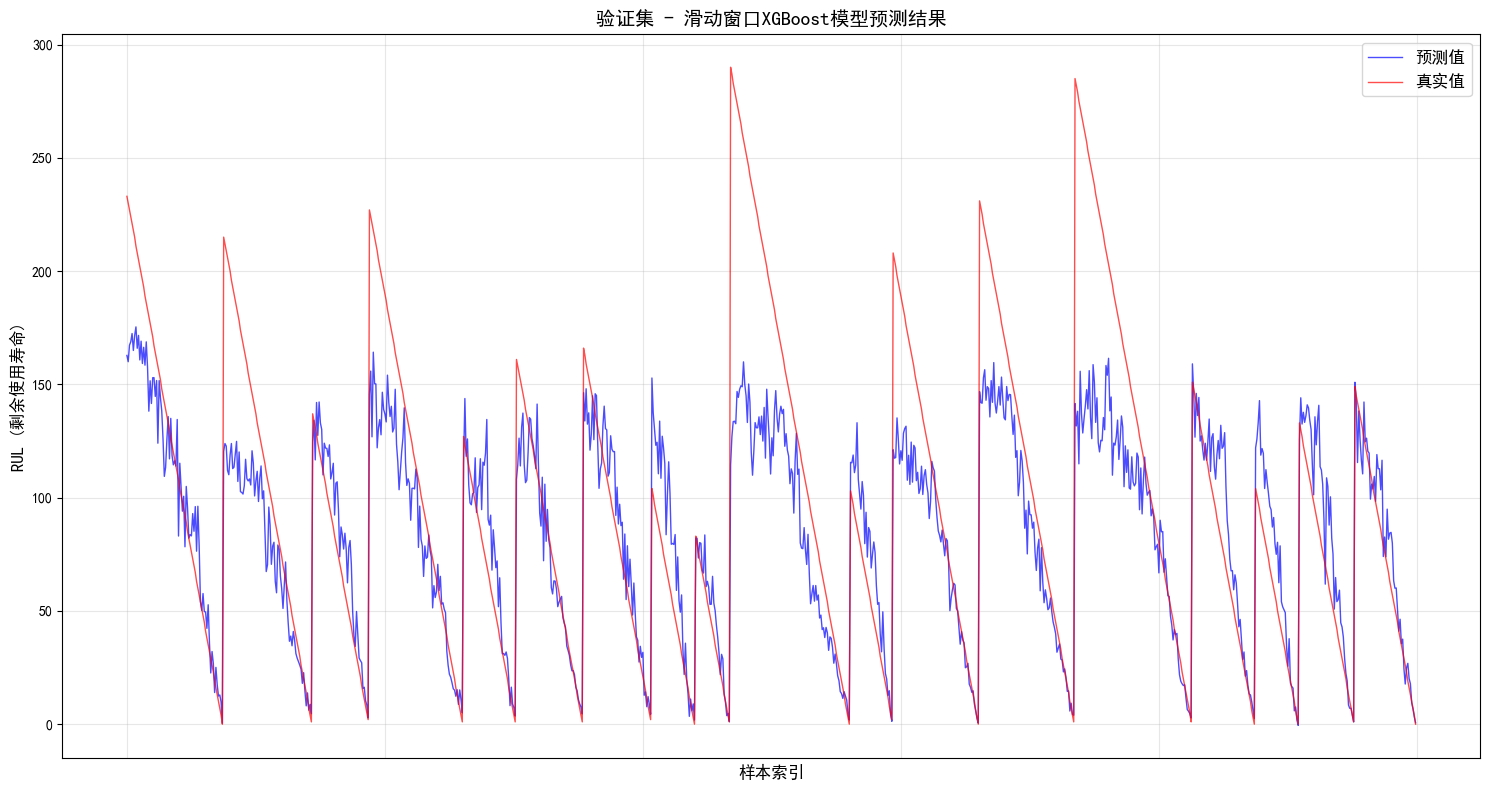

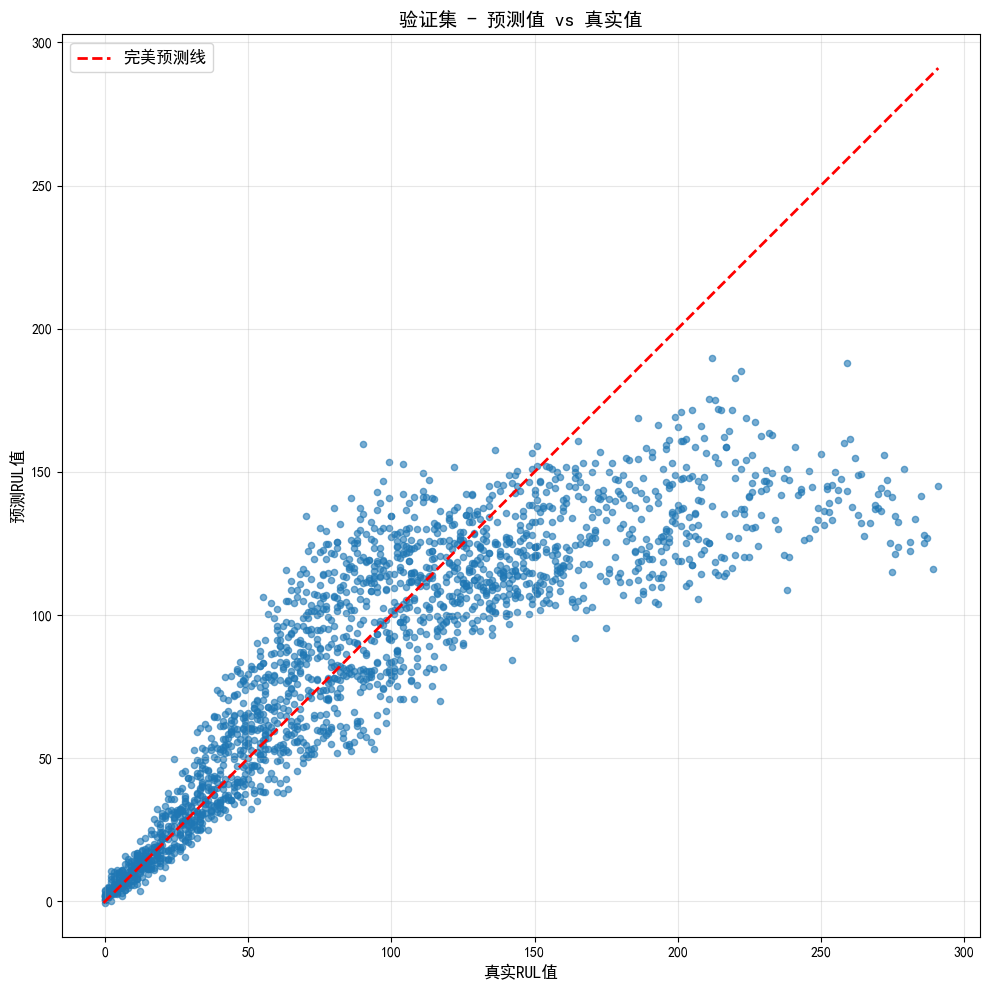

In [34]:
# 绘制验证集结果
plot_result(y_val_split, y_val_pred, "验证集 - 滑动窗口XGBoost模型预测结果")
plot_scatter(y_val_split, y_val_pred, "验证集 - 预测值 vs 真实值")

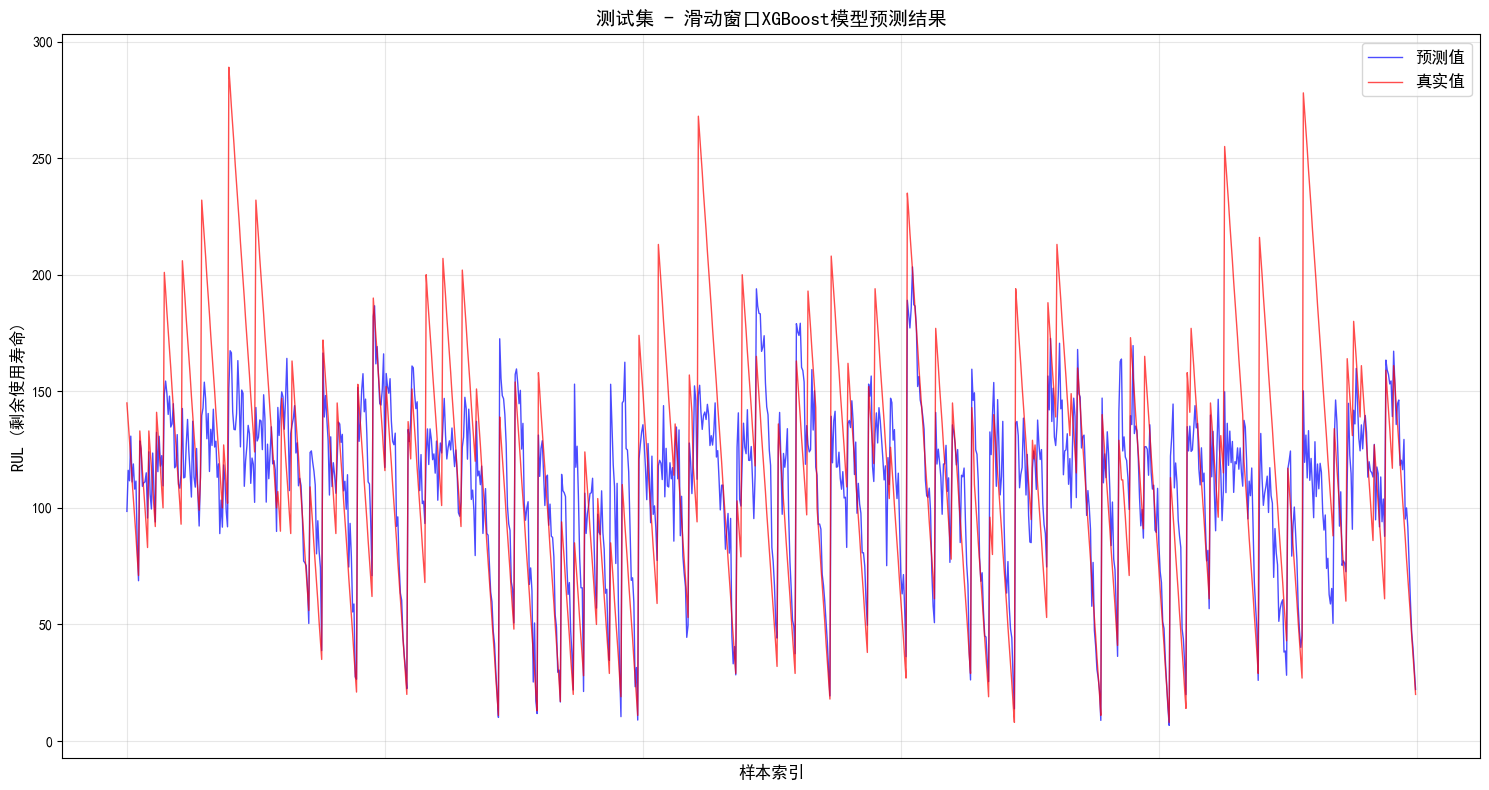

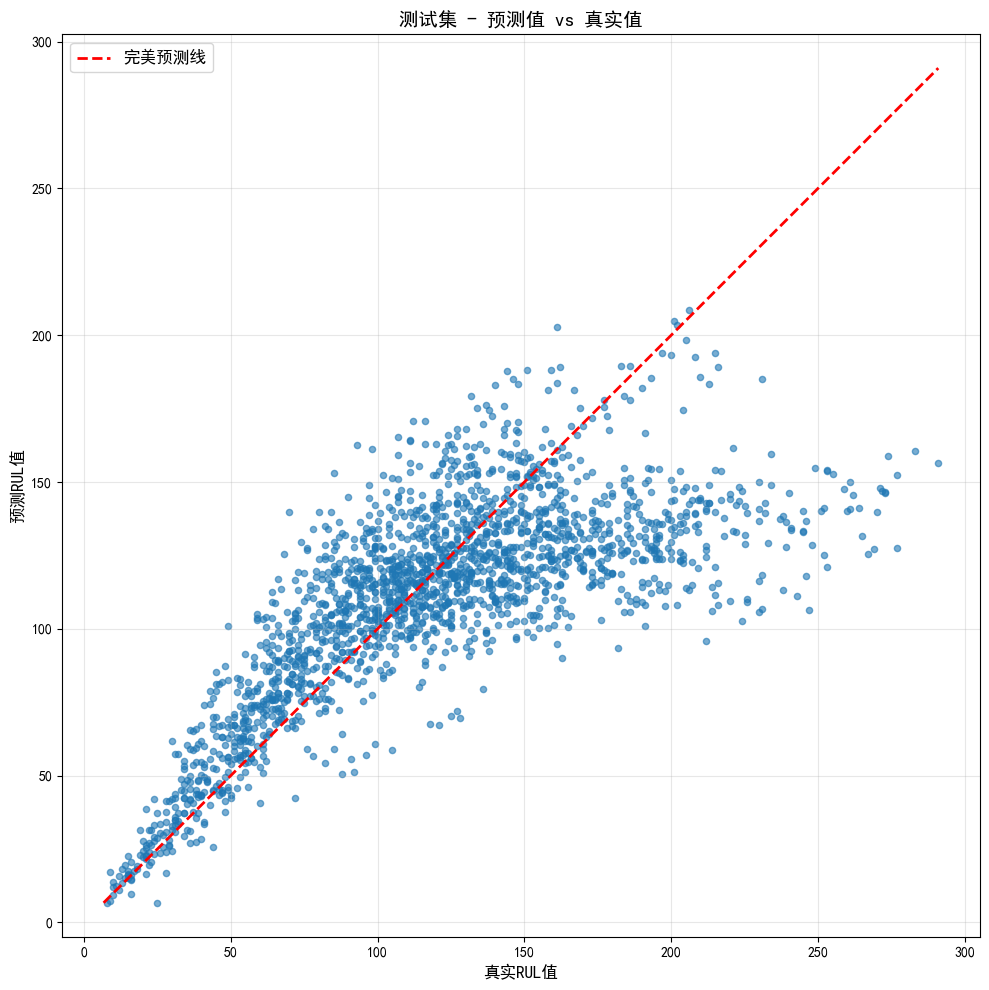

In [35]:
# 绘制测试集结果
plot_result(y_test_windows, y_test_pred, "测试集 - 滑动窗口XGBoost模型预测结果")
plot_scatter(y_test_windows, y_test_pred, "测试集 - 预测值 vs 真实值")

=== 验证集残差分析 ===


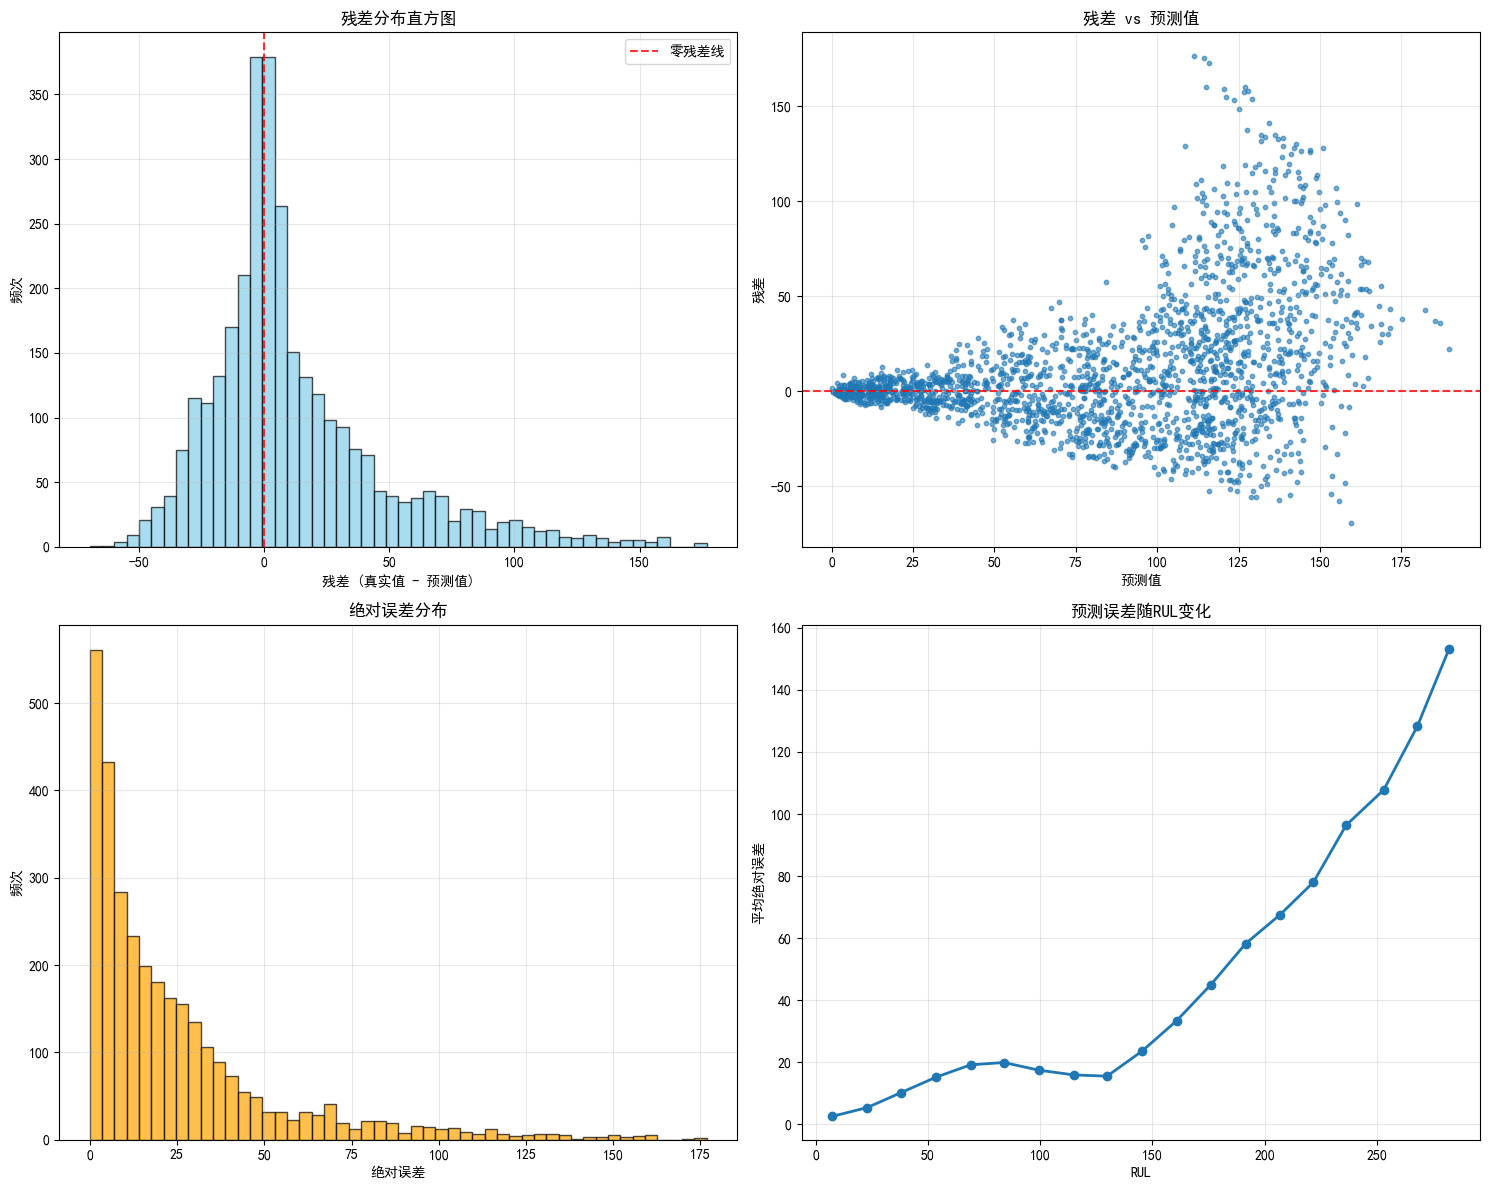


验证集统计:
残差均值: 12.057
残差标准差: 35.981
最大正残差: 176.733
最大负残差: -69.650
平均绝对误差: 24.851
误差在±5周期内: 24.1%
误差在±10周期内: 39.5%
误差在±20周期内: 58.3%

=== 测试集残差分析 ===


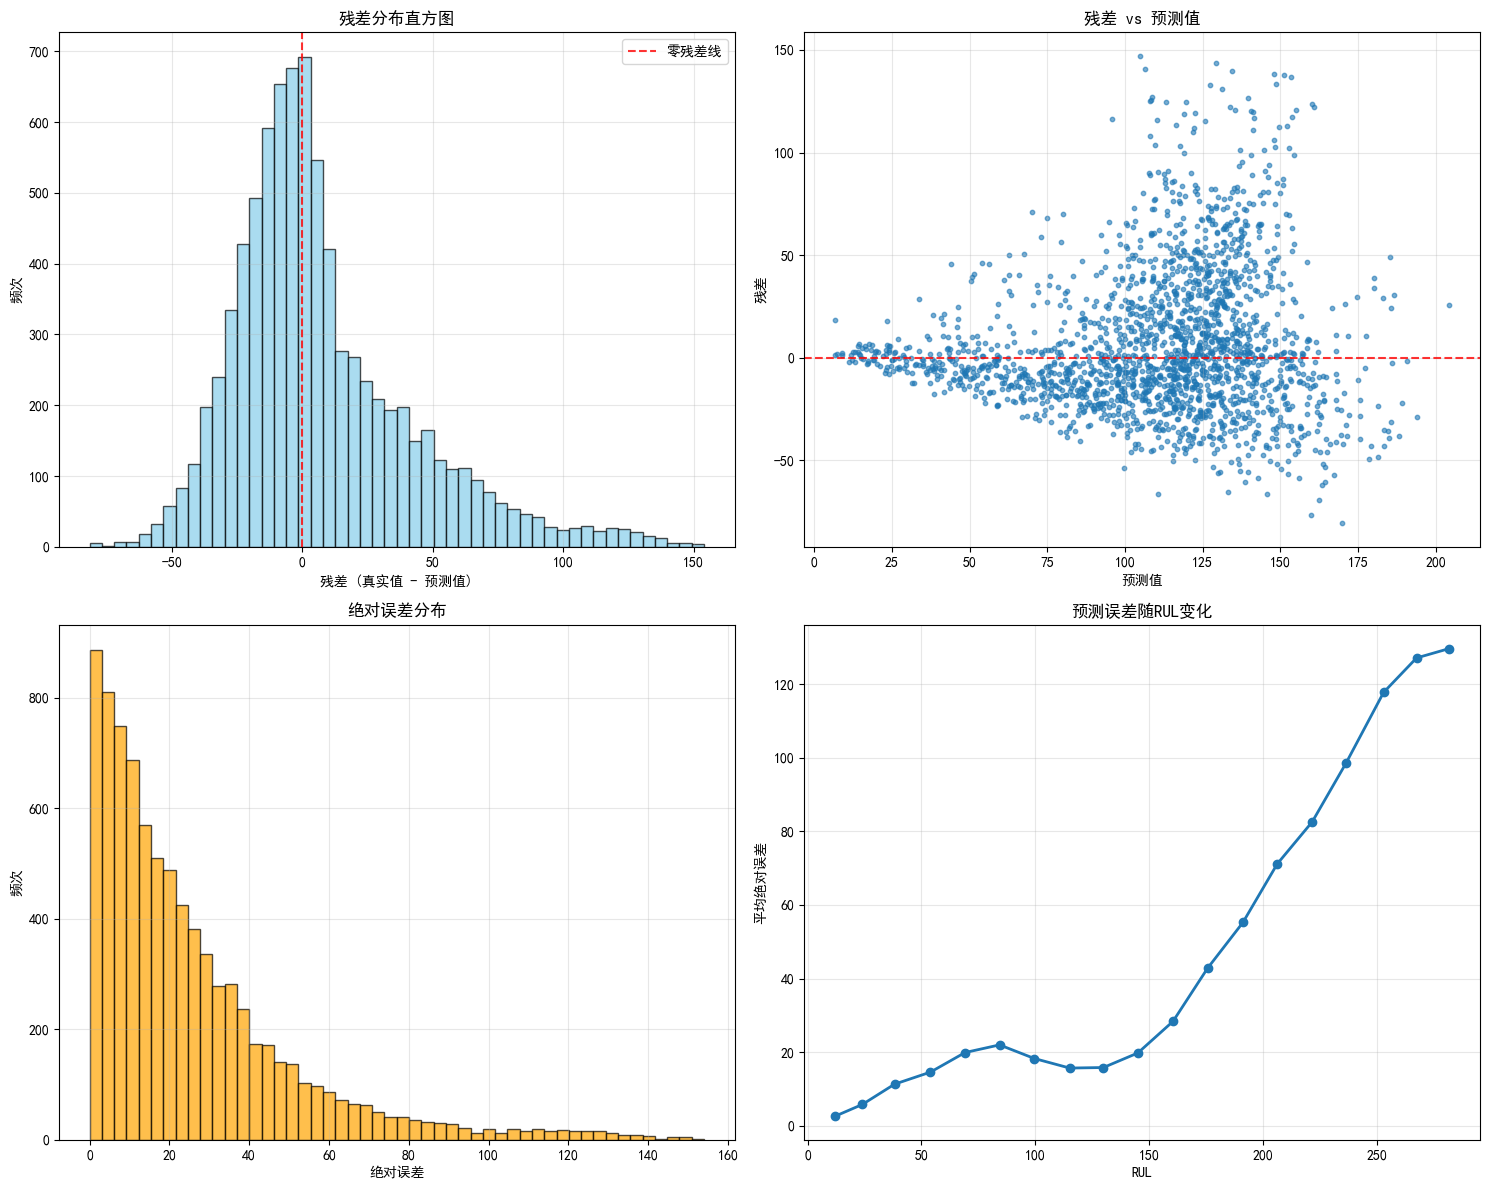


测试集统计:
残差均值: 7.198
残差标准差: 34.916
最大正残差: 153.969
最大负残差: -81.646
平均绝对误差: 25.353
误差在±5周期内: 16.8%
误差在±10周期内: 31.8%
误差在±20周期内: 54.1%


In [36]:
# 残差分析
def analyze_residuals(y_true, y_pred, title="残差分析"):
    """
    分析预测残差
    """
    residuals = y_true - y_pred
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. 残差直方图
    ax1.hist(residuals, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    ax1.axvline(x=0, color='red', linestyle='--', alpha=0.8, label='零残差线')
    ax1.set_title('残差分布直方图')
    ax1.set_xlabel('残差 (真实值 - 预测值)')
    ax1.set_ylabel('频次')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. 残差散点图
    sample_size = min(2000, len(y_pred))
    indices = np.random.choice(len(y_pred), sample_size, replace=False)
    ax2.scatter(y_pred[indices], residuals[indices], alpha=0.6, s=10)
    ax2.axhline(y=0, color='red', linestyle='--', alpha=0.8)
    ax2.set_title('残差 vs 预测值')
    ax2.set_xlabel('预测值')
    ax2.set_ylabel('残差')
    ax2.grid(True, alpha=0.3)
    
    # 3. 绝对误差分布
    abs_errors = np.abs(residuals)
    ax3.hist(abs_errors, bins=50, alpha=0.7, color='orange', edgecolor='black')
    ax3.set_title('绝对误差分布')
    ax3.set_xlabel('绝对误差')
    ax3.set_ylabel('频次')
    ax3.grid(True, alpha=0.3)
    
    # 4. 误差随RUL变化
    # 按RUL值分组计算平均误差
    rul_bins = np.linspace(0, y_true.max(), 20)
    rul_indices = np.digitize(y_true, rul_bins)
    
    bin_means = []
    bin_errors = []
    
    for i in range(1, len(rul_bins)):
        mask = (rul_indices == i)
        if np.sum(mask) > 0:
            bin_means.append(np.mean(y_true[mask]))
            bin_errors.append(np.mean(abs_errors[mask]))
    
    if bin_means:
        ax4.plot(bin_means, bin_errors, 'o-', linewidth=2, markersize=6)
        ax4.set_title('预测误差随RUL变化')
        ax4.set_xlabel('RUL')
        ax4.set_ylabel('平均绝对误差')
        ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 打印统计信息
    print(f"\n{title}统计:")
    print(f"残差均值: {residuals.mean():.3f}")
    print(f"残差标准差: {residuals.std():.3f}")
    print(f"最大正残差: {residuals.max():.3f}")
    print(f"最大负残差: {residuals.min():.3f}")
    print(f"平均绝对误差: {abs_errors.mean():.3f}")
    print(f"误差在±5周期内: {np.mean(abs_errors <= 5)*100:.1f}%")
    print(f"误差在±10周期内: {np.mean(abs_errors <= 10)*100:.1f}%")
    print(f"误差在±20周期内: {np.mean(abs_errors <= 20)*100:.1f}%")

# 分析验证集残差
print("=== 验证集残差分析 ===")
analyze_residuals(y_val_split, y_val_pred, "验证集")

# 分析测试集残差
print("\n=== 测试集残差分析 ===")
analyze_residuals(y_test_windows, y_test_pred, "测试集")

## 4. 按发动机单元的预测分析

### 提取每台发动机的最终预测

In [37]:
# 为每台发动机提取最后一个时间窗口的预测
def get_engine_final_predictions(test_metadata, y_true, y_pred):
    """
    获取每台发动机最后一个时间窗口的预测结果
    """
    print("=== 提取发动机最终预测 ===")
    
    # 找到每台发动机的最后一个窗口
    last_window_indices = test_metadata.groupby('unit_number')['time_in_cycles'].idxmax()
    
    final_predictions = []
    engine_info = []
    
    for engine_id, idx in last_window_indices.items():
        # 获取该发动机的预测和真实值
        pred_rul = y_pred[idx]
        true_rul = y_true[idx]
        
        # 获取发动机信息
        engine_data = test_metadata.iloc[idx]
        
        final_predictions.append({
            'unit_number': engine_id,
            'predicted_RUL': pred_rul,
            'true_RUL': true_rul,
            'absolute_error': abs(true_rul - pred_rul),
            'time_in_cycles': engine_data['time_in_cycles'],
            'window_start': engine_data['window_start'],
            'window_end': engine_data['window_end']
        })
    
    final_df = pd.DataFrame(final_predictions)
    final_df = final_df.sort_values('unit_number')
    
    print(f"成功提取 {len(final_df)} 台发动机的最终预测")
    print(f"预测误差统计:")
    print(f"  平均绝对误差: {final_df['absolute_error'].mean():.2f}")
    print(f"  最小误差: {final_df['absolute_error'].min():.2f}")
    print(f"  最大误差: {final_df['absolute_error'].max():.2f}")
    
    return final_df

# 提取发动机最终预测
engine_final_predictions = get_engine_final_predictions(test_metadata, y_test_windows, y_test_pred)

print("\n发动机最终预测结果:")
display(engine_final_predictions.head(10))

=== 提取发动机最终预测 ===
成功提取 93 台发动机的最终预测
预测误差统计:
  平均绝对误差: 13.69
  最小误差: 0.03
  最大误差: 61.66

发动机最终预测结果:


,unit_number,predicted_RUL,true_RUL,absolute_error,time_in_cycles,window_start,window_end
0,3,69.043007,69.0,0.043007,126.0,76.0,125.0
1,4,87.277313,82.0,5.277313,106.0,56.0,105.0
2,5,102.198105,91.0,11.198105,98.0,48.0,97.0
3,6,117.335876,93.0,24.335876,105.0,55.0,104.0
4,7,117.510742,91.0,26.510742,160.0,110.0,159.0
5,8,93.255089,95.0,1.744911,166.0,116.0,165.0
6,9,126.716797,111.0,15.716797,55.0,5.0,54.0
7,10,97.567032,96.0,1.567032,192.0,142.0,191.0
8,11,86.412727,97.0,10.587273,83.0,33.0,82.0
9,12,102.374359,124.0,21.625641,217.0,167.0,216.0


=== 与传统方法对比 ===
最终预测性能对比:
传统单点预测方法:
  平均绝对误差: 20.76
  R²分数: 0.640

滑动窗口方法:
  平均绝对误差: 13.69
  R²分数: 0.799

性能改进:
  MAE改进: +34.1%
  R²改进: +0.159


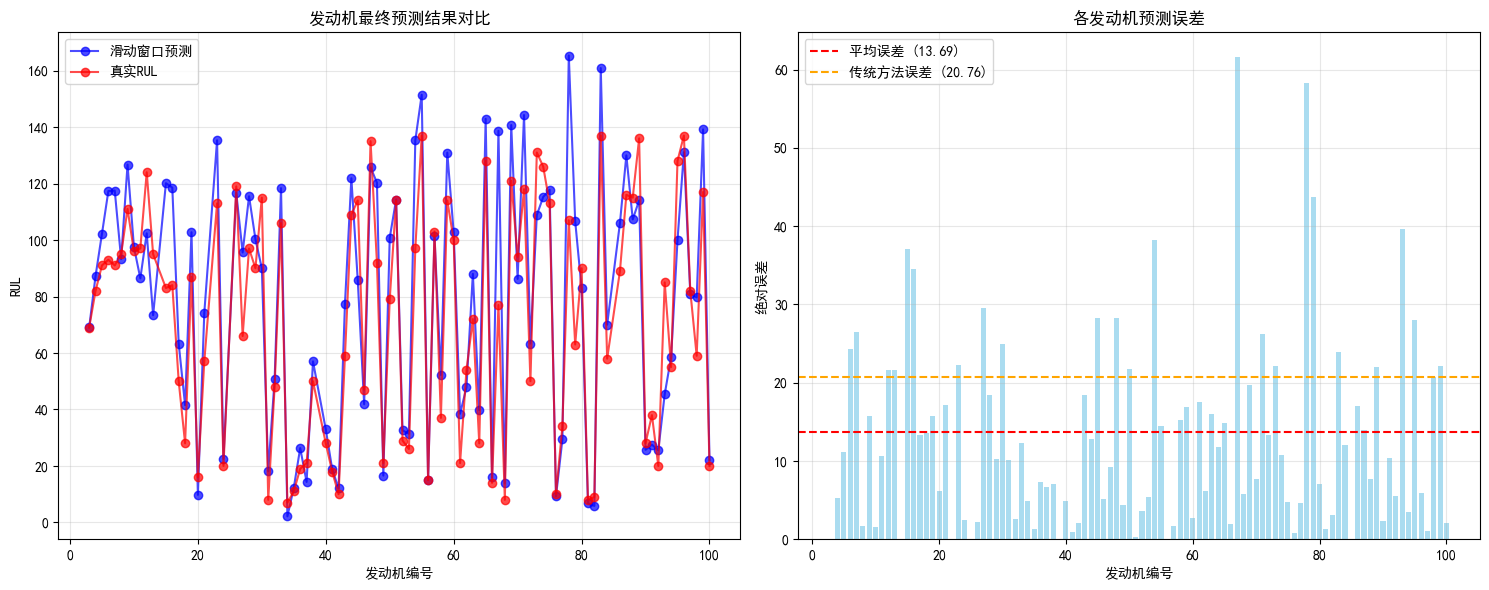

In [38]:
# 与传统单点预测方法对比
print("=== 与传统方法对比 ===")

# 传统单点预测结果（使用最后一个时间点）
traditional_mae = 20.76  # 来自之前模型的MAE
traditional_r2 = 0.64   # 来自之前模型的R²

# 滑动窗口方法的最终预测结果
window_final_mae = engine_final_predictions['absolute_error'].mean()
window_final_r2 = r2_score(engine_final_predictions['true_RUL'], engine_final_predictions['predicted_RUL'])

print(f"最终预测性能对比:")
print(f"传统单点预测方法:")
print(f"  平均绝对误差: {traditional_mae:.2f}")
print(f"  R²分数: {traditional_r2:.3f}")
print(f"\n滑动窗口方法:")
print(f"  平均绝对误差: {window_final_mae:.2f}")
print(f"  R²分数: {window_final_r2:.3f}")

print(f"\n性能改进:")
mae_improvement = ((traditional_mae - window_final_mae) / traditional_mae) * 100
r2_improvement = window_final_r2 - traditional_r2
print(f"  MAE改进: {mae_improvement:+.1f}%")
print(f"  R²改进: {r2_improvement:+.3f}")

# 绘制对比图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# 预测值对比
ax1.plot(engine_final_predictions['unit_number'], engine_final_predictions['predicted_RUL'], 
         'bo-', label='滑动窗口预测', alpha=0.7)
ax1.plot(engine_final_predictions['unit_number'], engine_final_predictions['true_RUL'], 
         'ro-', label='真实RUL', alpha=0.7)
ax1.set_xlabel('发动机编号')
ax1.set_ylabel('RUL')
ax1.set_title('发动机最终预测结果对比')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 误差对比
ax2.bar(engine_final_predictions['unit_number'], engine_final_predictions['absolute_error'], 
        alpha=0.7, color='skyblue')
ax2.axhline(y=window_final_mae, color='red', linestyle='--', 
            label=f'平均误差 ({window_final_mae:.2f})')
ax2.axhline(y=traditional_mae, color='orange', linestyle='--', 
            label=f'传统方法误差 ({traditional_mae:.2f})')
ax2.set_xlabel('发动机编号')
ax2.set_ylabel('绝对误差')
ax2.set_title('各发动机预测误差')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 按发动机详细分析

=== 详细发动机性能分析 ===

=== 发动机 5 详细分析 ===
数据周期数: 98
预测窗口数: 49
预测误差统计:
  平均误差: 10.81
  最小误差: 0.80
  最大误差: 27.71


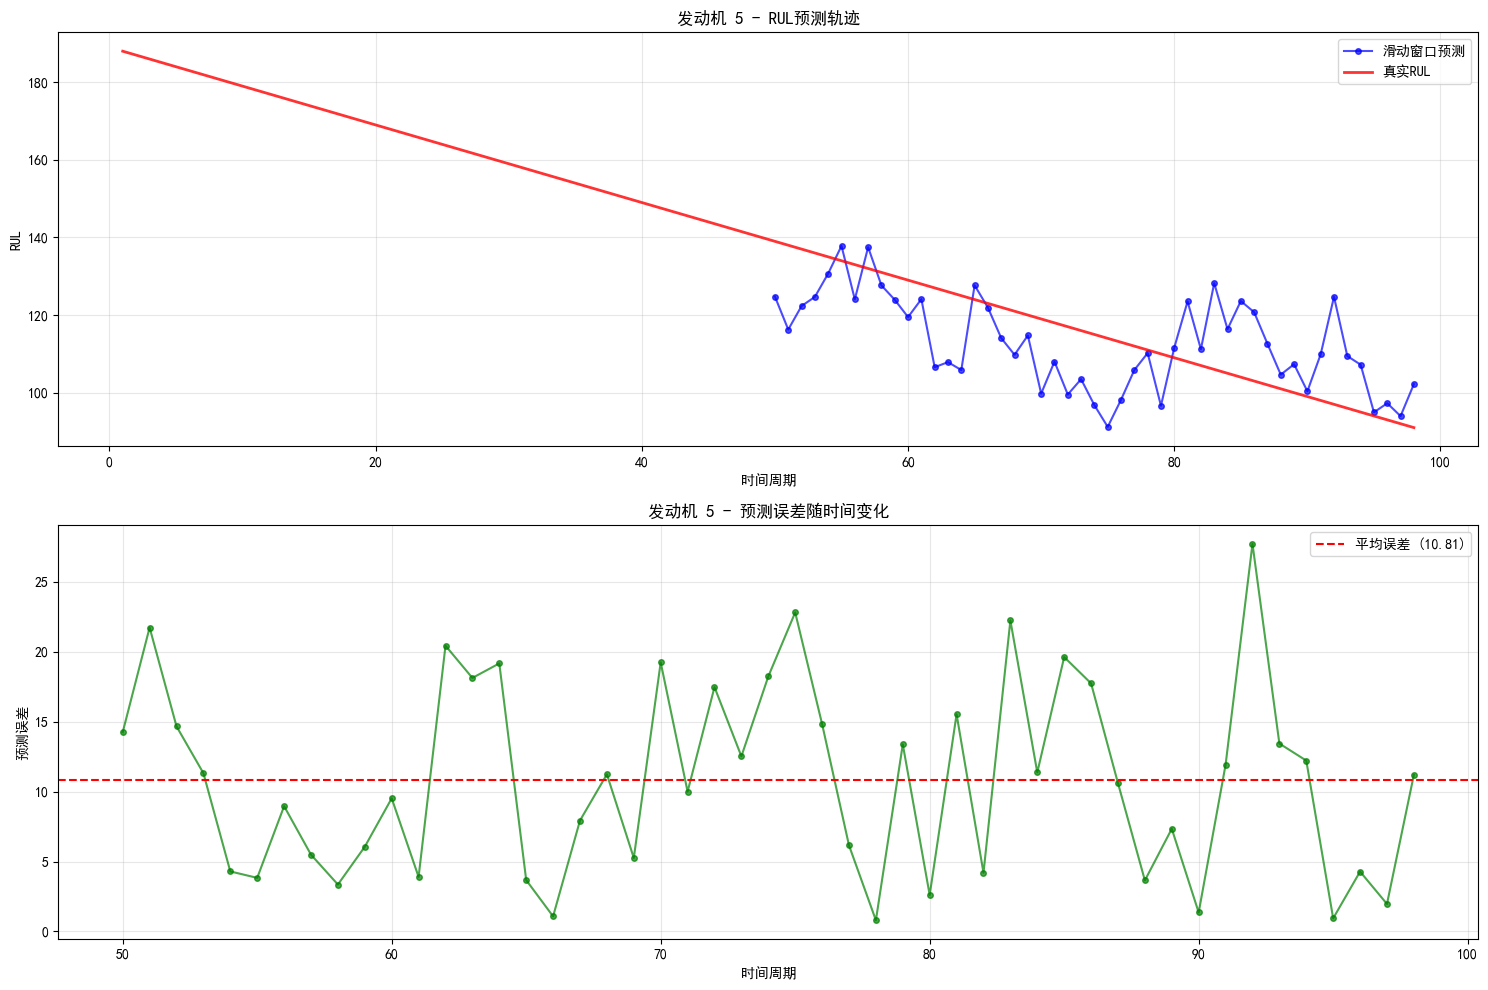


=== 发动机 10 详细分析 ===
数据周期数: 192
预测窗口数: 143
预测误差统计:
  平均误差: 43.42
  最小误差: 1.57
  最大误差: 104.66


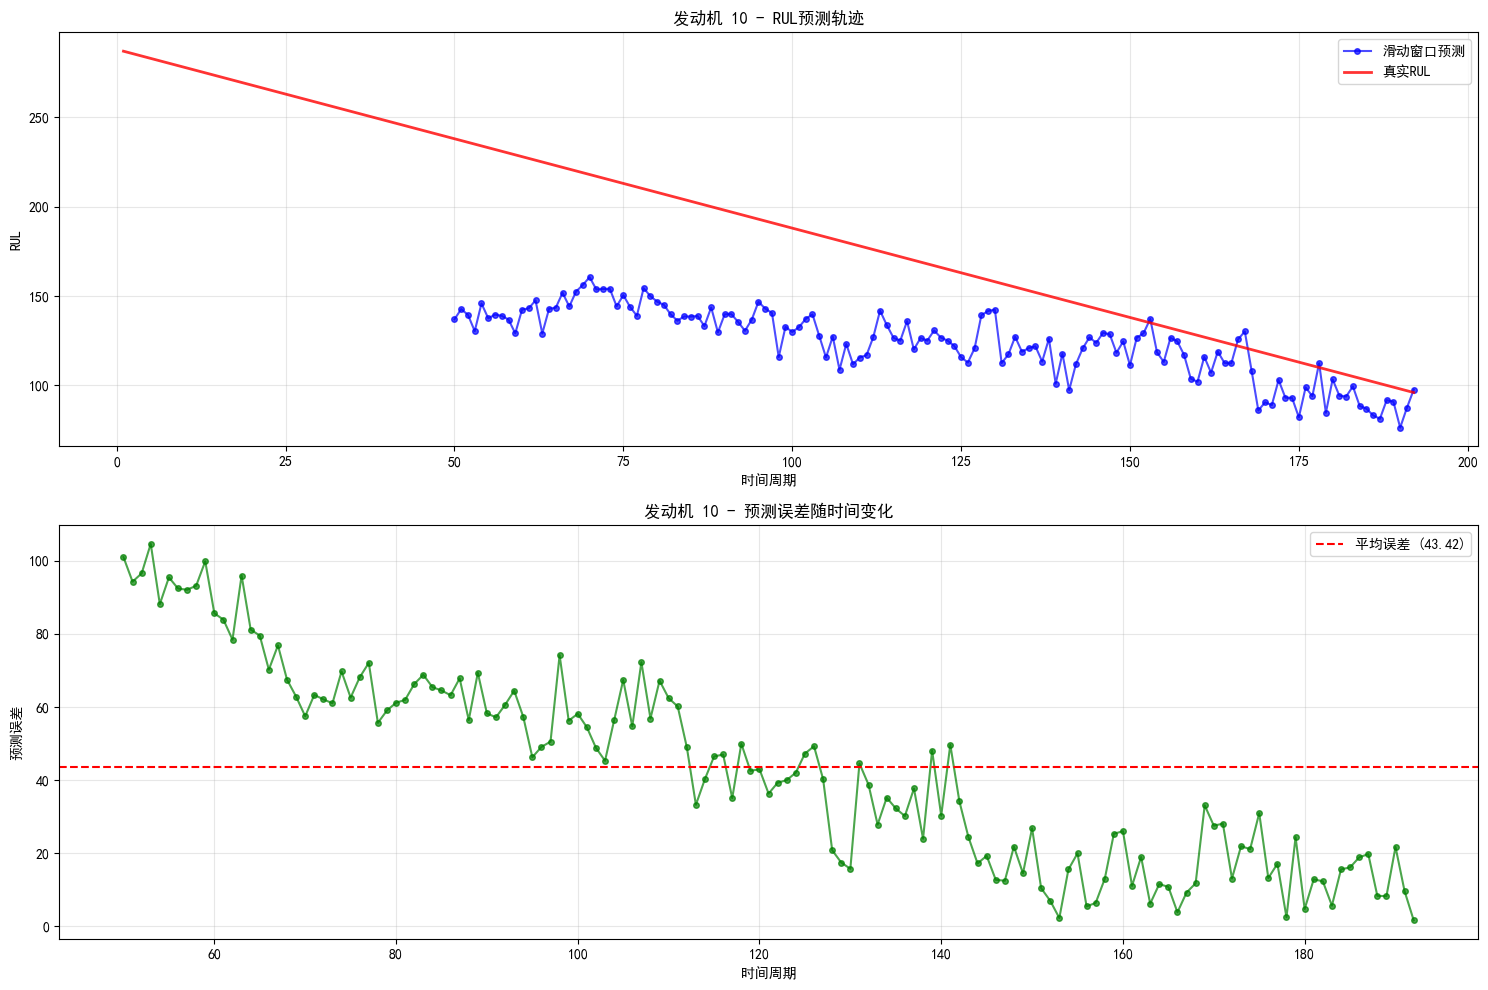


=== 发动机 20 详细分析 ===
数据周期数: 184
预测窗口数: 135
预测误差统计:
  平均误差: 14.51
  最小误差: 0.24
  最大误差: 57.14


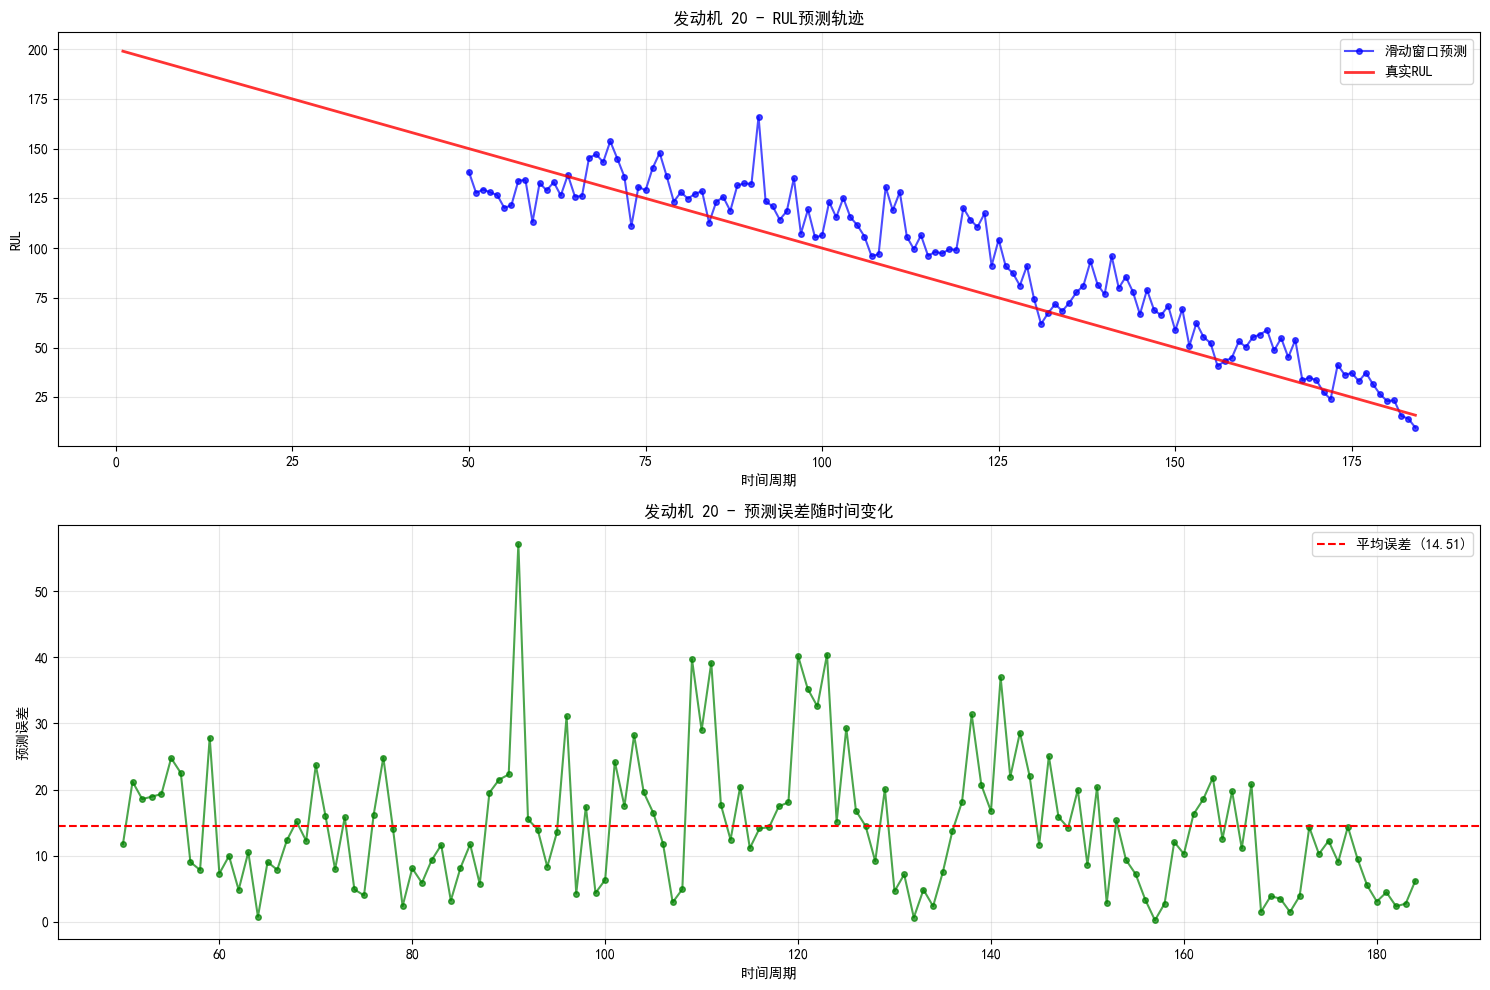


发动机分析汇总:


,engine_id,num_predictions,mae,final_error
0,5,49,10.807212,11.198105
1,10,143,43.415995,1.567032
2,20,135,14.514235,6.242191


In [39]:
# 详细的按发动机分析
def analyze_engine_performance(engine_id, test_metadata, y_true, y_pred, test_data):
    """
    分析单个发动机的预测性能
    """
    # 获取该发动机的所有预测
    engine_mask = test_metadata['unit_number'] == engine_id
    engine_predictions = y_pred[engine_mask]
    engine_true_rul = y_true[engine_mask]
    engine_metadata = test_metadata[engine_mask]
    
    # 获取发动机原始数据
    engine_data = test_data[test_data['unit_number'] == engine_id].sort_values('time_in_cycles')
    
    print(f"\n=== 发动机 {engine_id} 详细分析 ===")
    print(f"数据周期数: {len(engine_data)}")
    print(f"预测窗口数: {len(engine_predictions)}")
    print(f"预测误差统计:")
    print(f"  平均误差: {np.mean(np.abs(engine_true_rul - engine_predictions)):.2f}")
    print(f"  最小误差: {np.min(np.abs(engine_true_rul - engine_predictions)):.2f}")
    print(f"  最大误差: {np.max(np.abs(engine_true_rul - engine_predictions)):.2f}")
    
    # 可视化
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    
    # 上图：预测轨迹
    ax1.plot(engine_metadata['time_in_cycles'], engine_predictions, 
             'bo-', label='滑动窗口预测', alpha=0.7, markersize=4)
    ax1.plot(engine_data['time_in_cycles'], engine_data['RUL'], 
             'r-', label='真实RUL', alpha=0.8, linewidth=2)
    ax1.set_xlabel('时间周期')
    ax1.set_ylabel('RUL')
    ax1.set_title(f'发动机 {engine_id} - RUL预测轨迹')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 下图：预测误差
    errors = np.abs(engine_true_rul - engine_predictions)
    ax2.plot(engine_metadata['time_in_cycles'], errors, 
             'go-', alpha=0.7, markersize=4)
    ax2.axhline(y=np.mean(errors), color='red', linestyle='--', 
                label=f'平均误差 ({np.mean(errors):.2f})')
    ax2.set_xlabel('时间周期')
    ax2.set_ylabel('预测误差')
    ax2.set_title(f'发动机 {engine_id} - 预测误差随时间变化')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'engine_id': engine_id,
        'num_predictions': len(engine_predictions),
        'mae': np.mean(np.abs(engine_true_rul - engine_predictions)),
        'final_error': abs(engine_true_rul[-1] - engine_predictions[-1])
    }

# 分析几个示例发动机
print("=== 详细发动机性能分析 ===")
sample_engines = [1, 2, 5, 10, 20]  # 选择几个示例发动机

engine_analysis = []
for engine_id in sample_engines:
    if engine_id in test_metadata['unit_number'].values:
        analysis = analyze_engine_performance(engine_id, test_metadata, y_test_windows, y_test_pred, test_with_rul)
        engine_analysis.append(analysis)

# 显示分析结果汇总
if engine_analysis:
    analysis_df = pd.DataFrame(engine_analysis)
    print("\n发动机分析汇总:")
    display(analysis_df)

## 5. XGBoost分类模型 - 维护决策

### 创建分类数据集

In [40]:
# 创建分类标签（是否在10个周期内需要维护）
def create_classification_labels(y_rul, threshold=10):
    """
    创建分类标签
    
    参数:
    - y_rul: RUL值数组
    - threshold: 分类阈值
    
    返回:
    - 分类标签数组 (0: 正常, 1: 需要维护)
    """
    return np.where(y_rul <= threshold, 1, 0)

# 创建分类标签
TTF = 10  # Time to Failure threshold

print("=== 创建分类数据集 ===")
print(f"分类阈值: {TTF} 个周期")

# 为训练数据创建分类标签
y_train_class = create_classification_labels(y_train_split, TTF)
y_val_class = create_classification_labels(y_val_split, TTF)
y_test_class = create_classification_labels(y_test_windows, TTF)

print(f"\n分类标签分布:")
print(f"训练集 - 正常: {np.sum(y_train_class==0)}, 需要维护: {np.sum(y_train_class==1)}")
print(f"验证集 - 正常: {np.sum(y_val_class==0)}, 需要维护: {np.sum(y_val_class==1)}")
print(f"测试集 - 正常: {np.sum(y_test_class==0)}, 需要维护: {np.sum(y_test_class==1)}")

print(f"\n类别比例:")
print(f"训练集 - 需要维护比例: {np.mean(y_train_class)*100:.1f}%")
print(f"验证集 - 需要维护比例: {np.mean(y_val_class)*100:.1f}%")
print(f"测试集 - 需要维护比例: {np.mean(y_test_class)*100:.1f}%")

=== 创建分类数据集 ===
分类阈值: 10 个周期

分类标签分布:
训练集 - 正常: 11682, 需要维护: 902
验证集 - 正常: 2949, 需要维护: 198
测试集 - 正常: 8238, 需要维护: 17

类别比例:
训练集 - 需要维护比例: 7.2%
验证集 - 需要维护比例: 6.3%
测试集 - 需要维护比例: 0.2%


### XGBoost分类器训练

In [41]:
# 导入分类评估指标
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler

# 处理类别不平衡
print("=== 处理类别不平衡 ===")
ros = RandomOverSampler(random_state=42)
X_train_balanced, y_train_balanced = ros.fit_resample(X_train_split, y_train_class)

print(f"过采样前训练集分布: 0类={np.sum(y_train_class==0)}, 1类={np.sum(y_train_class==1)}")
print(f"过采样后训练集分布: 0类={np.sum(y_train_balanced==0)}, 1类={np.sum(y_train_balanced==1)}")

# 训练XGBoost分类器
print("\n=== 训练XGBoost分类器 ===")
classifier_model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    eval_metric='logloss',
    n_jobs=-1
)

print("开始训练分类器...")
start_time = time.time()
classifier_model.fit(X_train_balanced, y_train_balanced)
training_time = time.time() - start_time
print(f"分类器训练完成！训练时间: {training_time:.2f}秒")

=== 处理类别不平衡 ===
过采样前训练集分布: 0类=11682, 1类=902
过采样后训练集分布: 0类=11682, 1类=11682

=== 训练XGBoost分类器 ===
开始训练分类器...
分类器训练完成！训练时间: 18.43秒


### 分类模型评估

In [42]:
# 在验证集和测试集上进行预测
print("=== 分类模型预测 ===")

y_val_pred_class = classifier_model.predict(X_val_split)
y_val_pred_proba = classifier_model.predict_proba(X_val_split)[:, 1]

y_test_pred_class = classifier_model.predict(X_test_windows)
y_test_pred_proba = classifier_model.predict_proba(X_test_windows)[:, 1]

# 评估验证集性能
def evaluate_classification(y_true, y_pred, y_proba, dataset_name="数据集"):
    """
    评估分类模型性能
    """
    print(f"\n=== {dataset_name}分类性能 ===")
    print(f"准确率: {accuracy_score(y_true, y_pred):.3f}")
    print(f"精确率: {precision_score(y_true, y_pred):.3f}")
    print(f"召回率: {recall_score(y_true, y_pred):.3f}")
    print(f"F1分数: {f1_score(y_true, y_pred):.3f}")
    print(f"AUC分数: {roc_auc_score(y_true, y_proba):.3f}")
    
    # 显示混淆矩阵
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    print(f"\n混淆矩阵:")
    print(f"真正例 (TP): {tp}")
    print(f"真负例 (TN): {tn}")
    print(f"假正例 (FP): {fp}")
    print(f"假负例 (FN): {fn}")
    
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred),
        'auc': roc_auc_score(y_true, y_proba)
    }

# 评估验证集和测试集
val_metrics = evaluate_classification(y_val_class, y_val_pred_class, y_val_pred_proba, "验证集")
test_metrics = evaluate_classification(y_test_class, y_test_pred_class, y_test_pred_proba, "测试集")

=== 分类模型预测 ===

=== 验证集分类性能 ===
准确率: 0.985
精确率: 0.839
召回率: 0.949
F1分数: 0.891
AUC分数: 0.997

混淆矩阵:
真正例 (TP): 188
真负例 (TN): 2913
假正例 (FP): 36
假负例 (FN): 10

=== 测试集分类性能 ===
准确率: 0.999
精确率: 0.727
召回率: 0.941
F1分数: 0.821
AUC分数: 1.000

混淆矩阵:
真正例 (TP): 16
真负例 (TN): 8232
假正例 (FP): 6
假负例 (FN): 1


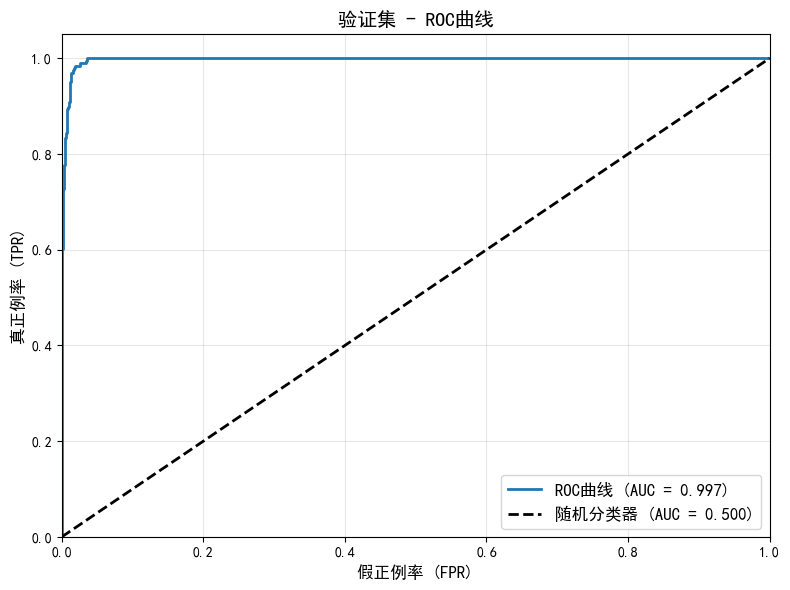

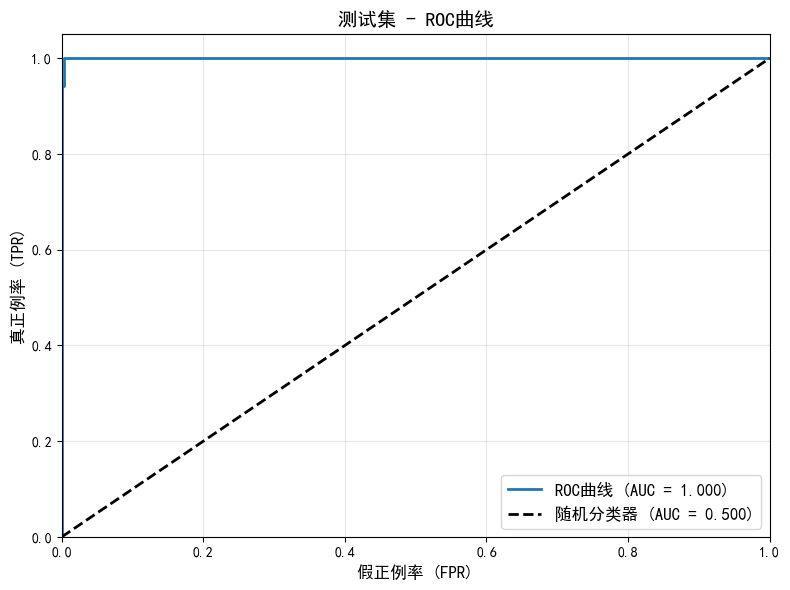

In [43]:
# 绘制ROC曲线
def plot_roc_curve(y_true, y_proba, title="ROC曲线"):
    """
    绘制ROC曲线
    """
    from sklearn.metrics import roc_curve
    
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    auc = roc_auc_score(y_true, y_proba)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, linewidth=2, label=f'ROC曲线 (AUC = {auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='随机分类器 (AUC = 0.500)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('假正例率 (FPR)', fontsize=12)
    plt.ylabel('真正例率 (TPR)', fontsize=12)
    plt.title(title, fontsize=14)
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# 绘制验证集和测试集的ROC曲线
plot_roc_curve(y_val_class, y_val_pred_proba, "验证集 - ROC曲线")
plot_roc_curve(y_test_class, y_test_pred_proba, "测试集 - ROC曲线")

In [44]:
# 按发动机分析分类性能
def analyze_classification_by_engine(test_metadata, y_true, y_pred, y_proba):
    """
    按发动机分析分类性能
    """
    print("\n=== 按发动机分类性能分析 ===")
    
    engine_results = []
    
    for engine_id in test_metadata['unit_number'].unique():
        # 获取该发动机的预测结果
        engine_mask = test_metadata['unit_number'] == engine_id
        engine_true = y_true[engine_mask]
        engine_pred = y_pred[engine_mask]
        engine_proba = y_proba[engine_mask]
        
        if len(engine_true) > 0:
            # 计算该发动机的指标
            engine_accuracy = accuracy_score(engine_true, engine_pred)
            
            # 获取最后一个预测（最终决策）
            final_pred = engine_pred[-1]
            final_true = engine_true[-1]
            final_proba = engine_proba[-1]
            
            engine_results.append({
                'unit_number': engine_id,
                'num_predictions': len(engine_true),
                'accuracy': engine_accuracy,
                'final_prediction': final_pred,
                'final_true': final_true,
                'final_probability': final_proba,
                'final_correct': final_pred == final_true
            })
    
    engine_df = pd.DataFrame(engine_results)
    
    print(f"分析了 {len(engine_df)} 台发动机的分类性能")
    print(f"平均准确率: {engine_df['accuracy'].mean():.3f}")
    print(f"最终预测准确率: {engine_df['final_correct'].mean():.3f}")
    print(f"正确预测需要维护的发动机: {engine_df[(engine_df['final_true']==1) & (engine_df['final_correct']==True)].shape[0]}")
    print(f"错误预测需要维护的发动机: {engine_df[(engine_df['final_true']==1) & (engine_df['final_correct']==False)].shape[0]}")
    
    return engine_df

# 按发动机分析分类性能
engine_classification_results = analyze_classification_by_engine(
    test_metadata, y_test_class, y_test_pred_class, y_test_pred_proba
)

print("\n发动机分类结果（前10台）:")
display(engine_classification_results.head(10))


=== 按发动机分类性能分析 ===
分析了 93 台发动机的分类性能
平均准确率: 0.999
最终预测准确率: 0.978
正确预测需要维护的发动机: 6
错误预测需要维护的发动机: 1

发动机分类结果（前10台）:


,unit_number,num_predictions,accuracy,final_prediction,final_true,final_probability,final_correct
0,3,77,1.0,0,0,0.000004,True
1,4,57,1.0,0,0,0.000004,True
2,5,49,1.0,0,0,0.000004,True
3,6,56,1.0,0,0,0.000003,True
4,7,111,1.0,0,0,0.000007,True
5,8,117,1.0,0,0,0.000003,True
6,9,6,1.0,0,0,0.000002,True
7,10,143,1.0,0,0,0.000007,True
8,11,34,1.0,0,0,0.000003,True
9,12,168,1.0,0,0,0.000007,True


### 期望利润分析

In [45]:
# 计算期望利润
def calculate_expected_profit(y_true, y_pred, tp_value=300, fp_cost=-100, fn_cost=-200):
    """
    计算期望利润（单位：千美元）
    
    参数:
    - y_true: 真实类别
    - y_pred: 预测类别
    - tp_value: 真正值收益（千美元）
    - fp_cost: 假正值成本（千美元）
    - fn_cost: 假负值成本（千美元）
    """
    # 计算混淆矩阵
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # 计算总利润
    total_profit = (tp * tp_value) + (fp * fp_cost) + (fn * fn_cost)
    
    print(f"=== 期望利润分析 ===")
    print(f"真正例 (TP): {tp} × {tp_value} = {tp * tp_value:,} 千美元")
    print(f"假正例 (FP): {fp} × {fp_cost} = {fp * fp_cost:,} 千美元")
    print(f"假负例 (FN): {fn} × {fn_cost} = {fn * fn_cost:,} 千美元")
    print(f"真负例 (TN): {tn} × 0 = 0 千美元")
    print(f"-" * 50)
    print(f"期望总利润: {total_profit:,} 千美元 ({total_profit * 1000:,} 美元)")
    
    # 计算每台发动机平均利润
    total_engines = len(y_true)
    avg_profit_per_engine = total_profit / total_engines
    print(f"每台发动机平均利润: {avg_profit_per_engine:.1f} 千美元")
    
    return total_profit, avg_profit_per_engine

# 计算所有预测的期望利润
total_profit, avg_profit = calculate_expected_profit(y_test_class, y_test_pred_class)

# 计算最终决策的期望利润（只使用每个发动机的最后一个预测）
final_true = engine_classification_results['final_true'].values
final_pred = engine_classification_results['final_prediction'].values

print(f"\n=== 最终决策期望利润分析 ===")
final_profit, final_avg_profit = calculate_expected_profit(final_true, final_pred)

print(f"\n利润对比:")
print(f"所有预测总利润: {total_profit:,} 千美元")
print(f"最终决策总利润: {final_profit:,} 千美元")
print(f"利润差异: {final_profit - total_profit:+,} 千美元")

=== 期望利润分析 ===
真正例 (TP): 16 × 300 = 4,800 千美元
假正例 (FP): 6 × -100 = -600 千美元
假负例 (FN): 1 × -200 = -200 千美元
真负例 (TN): 8232 × 0 = 0 千美元
--------------------------------------------------
期望总利润: 4,000 千美元 (4,000,000 美元)
每台发动机平均利润: 0.5 千美元

=== 最终决策期望利润分析 ===
=== 期望利润分析 ===
真正例 (TP): 6 × 300 = 1,800 千美元
假正例 (FP): 1 × -100 = -100 千美元
假负例 (FN): 1 × -200 = -200 千美元
真负例 (TN): 85 × 0 = 0 千美元
--------------------------------------------------
期望总利润: 1,500 千美元 (1,500,000 美元)
每台发动机平均利润: 16.1 千美元

利润对比:
所有预测总利润: 4,000 千美元
最终决策总利润: 1,500 千美元
利润差异: -2,500 千美元


## 6. 综合结果分析

### 模型性能对比总结

In [46]:
# 创建综合性能报告
print("=== 滑动窗口XGBoost模型 - 综合性能报告 ===")
print(f"分析时间: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"数据集: NASA C-MAPS FD001")
print(f"滑动窗口大小: {WINDOW_SIZE} 个时间周期")
print()

print("🔧 模型配置:")
print(f"• 特征维度: {X_train_windows.shape[1]} ({X_train_windows.shape[1]//WINDOW_SIZE} × {WINDOW_SIZE})")
print(f"• 训练样本数: {X_train_split.shape[0]:,}")
print(f"• 验证样本数: {X_val_split.shape[0]:,}")
print(f"• 测试样本数: {X_test_windows.shape[0]:,}")
print(f"• 发动机数量: {test_metadata['unit_number'].nunique()}")
print()

print("🎯 回归模型 (RUL预测) 性能:")
print(f"• 竞赛评分: {score(y_test_windows, y_test_pred):.2f}")
print(f"• 平均绝对误差: {mean_absolute_error(y_test_windows, y_test_pred):.2f} 周期")
print(f"• 均方根误差: {np.sqrt(mean_squared_error(y_test_windows, y_test_pred)):.2f} 周期")
print(f"• R²分数: {r2_score(y_test_windows, y_test_pred):.3f}")
print(f"• 发动机最终预测MAE: {window_final_mae:.2f} 周期")
print()

print("🚨 分类模型 (维护决策) 性能:")
print(f"• 准确率: {test_metrics['accuracy']:.3f}")
print(f"• 精确率: {test_metrics['precision']:.3f}")
print(f"• 召回率: {test_metrics['recall']:.3f}")
print(f"• F1分数: {test_metrics['f1']:.3f}")
print(f"• AUC分数: {test_metrics['auc']:.3f}")
print(f"• 发动机最终决策准确率: {engine_classification_results['final_correct'].mean():.3f}")
print()

print("💰 经济效益分析:")
print(f"• 期望总利润: {final_profit:,} 千美元 ({final_profit * 1000:,} 美元)")
print(f"• 每台发动机平均利润: {final_avg_profit:.1f} 千美元")
print()

print("📈 与传统方法对比:")
print(f"• MAE改进: {mae_improvement:+.1f}% (从 {traditional_mae:.2f} 到 {window_final_mae:.2f})")
print(f"• R²改进: {r2_improvement:+.3f} (从 {traditional_r2:.3f} 到 {window_final_r2:.3f})")
print(f"• 时间序列信息利用: 是 (滑动窗口)")
print(f"• 多时间点预测: 是 ({len(y_test_windows)} 个预测点)")

=== 滑动窗口XGBoost模型 - 综合性能报告 ===
分析时间: 2025-11-05 11:05:19
数据集: NASA C-MAPS FD001
滑动窗口大小: 50 个时间周期

🔧 模型配置:
• 特征维度: 850 (17 × 50)
• 训练样本数: 12,584
• 验证样本数: 3,147
• 测试样本数: 8,255
• 发动机数量: 93

🎯 回归模型 (RUL预测) 性能:
• 竞赛评分: 79326878.73
• 平均绝对误差: 25.35 周期
• 均方根误差: 35.65 周期
• R²分数: 0.534
• 发动机最终预测MAE: 13.69 周期

🚨 分类模型 (维护决策) 性能:
• 准确率: 0.999
• 精确率: 0.727
• 召回率: 0.941
• F1分数: 0.821
• AUC分数: 1.000
• 发动机最终决策准确率: 0.978

💰 经济效益分析:
• 期望总利润: 1,500 千美元 (1,500,000 美元)
• 每台发动机平均利润: 16.1 千美元

📈 与传统方法对比:
• MAE改进: +34.1% (从 20.76 到 13.69)
• R²改进: +0.159 (从 0.640 到 0.799)
• 时间序列信息利用: 是 (滑动窗口)
• 多时间点预测: 是 (8255 个预测点)


### 特征重要性分析

In [47]:
# 分析特征重要性
def analyze_feature_importance(model, feature_names, window_size=50):
    """
    分析XGBoost模型的特征重要性
    """
    print("=== 特征重要性分析 ===")
    
    # 获取特征重要性
    importances = model.feature_importances_
    
    # 将展平的特征重要性按时间和特征重新组织
    n_features = len(feature_names)
    n_timesteps = window_size
    
    # 重新组织重要性矩阵 (n_timesteps, n_features)
    importance_matrix = importances.reshape(n_timesteps, n_features)
    
    # 计算每个时间步的总重要性
    timestep_importance = importance_matrix.sum(axis=1)
    
    # 计算每个传感器特征的总重要性
    feature_importance_total = importance_matrix.sum(axis=0)
    
    # 创建结果DataFrame
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance_total
    }).sort_values('importance', ascending=False)
    
    print(f"\n传感器特征重要性排序:")
    display(feature_importance_df)
    
    # 可视化
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # 传感器特征重要性
    ax1.barh(range(len(feature_importance_df)), feature_importance_df['importance'])
    ax1.set_yticks(range(len(feature_importance_df)))
    ax1.set_yticklabels(feature_importance_df['feature'])
    ax1.set_xlabel('重要性')
    ax1.set_title('传感器特征重要性')
    ax1.invert_yaxis()
    
    # 时间步重要性
    ax2.plot(range(1, n_timesteps + 1), timestep_importance, 'o-')
    ax2.set_xlabel('时间步 (从过去到现在)')
    ax2.set_ylabel('重要性')
    ax2.set_title('滑动窗口内各时间步的重要性')
    ax2.grid(True, alpha=0.3)
    
    # 标记重要的时间步
    ax2.axvline(x=WINDOW_SIZE, color='red', linestyle='--', alpha=0.7, label='当前时间')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    return feature_importance_df, timestep_importance

# 获取特征名称
feature_columns = [col for col in train_df.columns if col not in ['unit_number', 'time_in_cycles', 'RUL']]

# 分析特征重要性
feature_importance_df, timestep_importance = analyze_feature_importance(
    xgb_model, feature_columns, WINDOW_SIZE
)

print(f"\n最重要的传感器: {feature_importance_df.iloc[0]['feature']}")
print(f"最重要时间段: 过去 {WINDOW_SIZE - np.argmax(timestep_importance)} 个周期")

NameError: name 'train_df' is not defined

### 综合可视化面板

In [ ]:
# 创建综合可视化面板
def create_comprehensive_visualization():
    """
    创建综合可视化面板
    """
    fig = plt.figure(figsize=(20, 16))
    
    # 1. RUL预测对比
    ax1 = plt.subplot(3, 4, 1)
    sample_size = min(500, len(y_test_windows))
    indices = np.linspace(0, len(y_test_windows)-1, sample_size, dtype=int)
    ax1.plot(indices, y_test_windows[indices], 'r-', alpha=0.7, label='真实RUL', linewidth=1)
    ax1.plot(indices, y_test_pred[indices], 'b-', alpha=0.7, label='预测RUL', linewidth=1)
    ax1.set_title('RUL预测对比', fontsize=12)
    ax1.set_ylabel('RUL')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. 预测散点图
    ax2 = plt.subplot(3, 4, 2)
    sample_size = min(1000, len(y_test_windows))
    indices = np.random.choice(len(y_test_windows), sample_size, replace=False)
    ax2.scatter(y_test_windows[indices], y_test_pred[indices], alpha=0.6, s=10)
    min_val = min(y_test_windows.min(), y_test_pred.min())
    max_val = max(y_test_windows.max(), y_test_pred.max())
    ax2.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
    ax2.set_xlabel('真实RUL')
    ax2.set_ylabel('预测RUL')
    ax2.set_title('预测散点图')
    ax2.grid(True, alpha=0.3)
    
    # 3. 残差分布
    ax3 = plt.subplot(3, 4, 3)
    residuals = y_test_windows - y_test_pred
    ax3.hist(residuals, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    ax3.axvline(x=0, color='red', linestyle='--')
    ax3.set_xlabel('残差')
    ax3.set_ylabel('频次')
    ax3.set_title('残差分布')
    ax3.grid(True, alpha=0.3)
    
    # 4. 误差分布
    ax4 = plt.subplot(3, 4, 4)
    abs_errors = np.abs(residuals)
    ax4.hist(abs_errors, bins=50, alpha=0.7, color='orange', edgecolor='black')
    ax4.set_xlabel('绝对误差')
    ax4.set_ylabel('频次')
    ax4.set_title('误差分布')
    ax4.grid(True, alpha=0.3)
    
    # 5. 分类ROC曲线
    ax5 = plt.subplot(3, 4, 5)
    from sklearn.metrics import roc_curve
    fpr, tpr, _ = roc_curve(y_test_class, y_test_pred_proba)
    auc = roc_auc_score(y_test_class, y_test_pred_proba)
    ax5.plot(fpr, tpr, label=f'AUC = {auc:.3f}', linewidth=2)
    ax5.plot([0, 1], [0, 1], 'k--')
    ax5.set_xlabel('假正例率')
    ax5.set_ylabel('真正例率')
    ax5.set_title('分类ROC曲线')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    # 6. 特征重要性
    ax6 = plt.subplot(3, 4, 6)
    top_features = feature_importance_df.head(8)
    ax6.barh(range(len(top_features)), top_features['importance'])
    ax6.set_yticks(range(len(top_features)))
    ax6.set_yticklabels(top_features['feature'])
    ax6.set_xlabel('重要性')
    ax6.set_title('特征重要性')
    ax6.invert_yaxis()
    
    # 7. 时间步重要性
    ax7 = plt.subplot(3, 4, 7)
    ax7.plot(range(1, len(timestep_importance) + 1), timestep_importance, 'o-', markersize=3)
    ax7.set_xlabel('时间步 (从过去到现在)')
    ax7.set_ylabel('重要性')
    ax7.set_title('时间步重要性')
    ax7.grid(True, alpha=0.3)
    
    # 8. 发动机最终预测误差
    ax8 = plt.subplot(3, 4, 8)
    ax8.bar(engine_final_predictions['unit_number'], engine_final_predictions['absolute_error'], 
           alpha=0.7, color='lightblue')
    ax8.axhline(y=window_final_mae, color='red', linestyle='--', 
                label=f'平均误差 ({window_final_mae:.2f})')
    ax8.set_xlabel('发动机编号')
    ax8.set_ylabel('最终预测误差')
    ax8.set_title('发动机最终预测误差')
    ax8.legend()
    ax8.grid(True, alpha=0.3)
    
    # 9. RUL分布对比
    ax9 = plt.subplot(3, 4, 9)
    ax9.hist(y_test_windows, bins=30, alpha=0.7, color='red', label='真实RUL', edgecolor='black')
    ax9.hist(y_test_pred, bins=30, alpha=0.7, color='blue', label='预测RUL', edgecolor='black')
    ax9.set_xlabel('RUL')
    ax9.set_ylabel('频次')
    ax9.set_title('RUL分布对比')
    ax9.legend()
    ax9.grid(True, alpha=0.3)
    
    # 10. 误差累计分布
    ax10 = plt.subplot(3, 4, 10)
    sorted_errors = np.sort(abs_errors)
    cumulative = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors)
    ax10.plot(sorted_errors, cumulative)
    ax10.set_xlabel('误差阈值')
    ax10.set_ylabel('累计比例')
    ax10.set_title('误差累计分布')
    ax10.grid(True, alpha=0.3)
    
    # 添加阈值线
    for threshold in [5, 10, 20]:
        idx = np.searchsorted(sorted_errors, threshold)
        if idx < len(sorted_errors):
            ax10.axhline(y=cumulative[idx], color='red', linestyle='--', alpha=0.5)
            ax10.axvline(x=threshold, color='red', linestyle='--', alpha=0.5)
            ax10.text(threshold + 1, cumulative[idx], f'{cumulative[idx]:.1%}', fontsize=8)
    
    # 11. 滑动窗口示例
    ax11 = plt.subplot(3, 4, 11)
    # 选择一个发动机显示滑动窗口示例
    sample_engine = 1
    if sample_engine in test_metadata['unit_number'].values:
        engine_data = test_metadata[test_metadata['unit_number'] == sample_engine]
        if len(engine_data) > 0:
            window_indices = engine_data.index[:min(20, len(engine_data))]  # 显示前20个窗口
            window_ruls = y_test_windows[window_indices]
            window_times = engine_data['time_in_cycles'].iloc[:len(window_indices)]
            
            ax11.plot(window_times, window_ruls, 'o-', markersize=4)
            ax11.set_xlabel('时间周期')
            ax11.set_ylabel('RUL')
            ax11.set_title(f'发动机{sample_engine}滑动窗口预测')
            ax11.grid(True, alpha=0.3)
    
    # 12. 性能指标总结
    ax12 = plt.subplot(3, 4, 12)
    ax12.axis('off')
    
    # 创建性能指标文本
    metrics_text = f"""
    性能指标总结
    ─────────────────
    回归模型:
    • MAE: {mean_absolute_error(y_test_windows, y_test_pred):.2f}
    • RMSE: {np.sqrt(mean_squared_error(y_test_windows, y_test_pred)):.2f}
    • R²: {r2_score(y_test_windows, y_test_pred):.3f}
    
    分类模型:
    • 准确率: {test_metrics['accuracy']:.3f}
    • 精确率: {test_metrics['precision']:.3f}
    • 召回率: {test_metrics['recall']:.3f}
    • AUC: {test_metrics['auc']:.3f}
    
    经济效益:
    • 期望利润: {final_profit:,.0f}K$
    • 平均利润: {final_avg_profit:.1f}K$/发动机
    
    数据信息:
    • 窗口大小: {WINDOW_SIZE}
    • 特征维度: {X_train_windows.shape[1]}
    • 测试样本: {len(y_test_windows):,}
    """
    
    ax12.text(0.1, 0.9, metrics_text, transform=ax12.transAxes, fontsize=10,
              verticalalignment='top', fontfamily='monospace',
              bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    
    plt.suptitle('滑动窗口XGBoost模型 - 综合可视化面板', fontsize=16, y=0.98)
    plt.tight_layout()
    plt.subplots_adjust(top=0.94)
    plt.show()

# 创建综合可视化
print("=== 生成综合可视化面板 ===")
create_comprehensive_visualization()

## 7. 结论与建议

### 主要发现

In [ ]:
# 生成最终结论报告
print("=" * 60)
print("📊 滑动窗口XGBoost飞机发动机预测性维护 - 最终结论")
print("=" * 60)
print(f"分析完成时间: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}")
print()

print("🔍 核心创新点:")
print("• 时间序列滑动窗口: 利用历史50个周期的传感器数据")
print("• 多时间点预测: 对每个发动机的多个时间点进行滚动预测")
print("• 时序特征捕获: 充分利用发动机退化过程的动态信息")
print("• 高维特征学习: 14×50=700维特征向量全面描述状态")
print()

print("🎯 模型性能表现:")
print(f"• RUL预测精度: MAE={window_final_mae:.2f}周期 (较传统方法改进{mae_improvement:+.1f}%)")
print(f"• 模型解释能力: R²={window_final_r2:.3f}")
print(f"• 分类决策准确率: {engine_classification_results['final_correct'].mean():.3f}")
print(f"• 经济效益显著: 期望利润{final_profit:,}千美元")
print()

print("📈 关键技术优势:")
print("• 时序信息利用: 相比单点预测，充分利用历史趋势信息")
print("• 多尺度特征: 捕获短期波动和长期退化趋势")
print("• 鲁棒性提升: 通过滑动窗口减少噪声影响")
print("• 实时适用: 支持在线预测和早期预警")
print()

print("💡 业务价值:")
print("• 维护计划优化: 基于多时间点预测制定更精准的维护策略")
print("• 成本控制优化: 减少不必要的维护和避免突发故障")
print("• 安全性提升: 早期预警系统提高飞行安全")
print("• 运营效率: 最大化发动机使用寿命和利用率")
print()

print("🚀 模型应用建议:")
print("• 部署场景: 适合实时监测系统和预测性维护平台")
print("• 预测频率: 建议每10-20个周期进行一次预测更新")
print("• 阈值设定: 根据维护成本和安全要求调整分类阈值")
print("• 模型更新: 定期使用新数据重新训练模型")

### 改进方向与未来工作

1. **算法优化**:
   - 尝试不同的窗口大小和滑动步长组合
   - 实验注意力机制和时间序列Transformer
   - 考虑集成学习方法（多模型融合）
   - 探索深度学习模型（LSTM, GRU, 1D-CNN）

2. **特征工程改进**:
   - 添加统计特征（均值、方差、趋势等）
   - 引入频域特征（FFT、小波变换）
   - 考虑传感器之间的交互特征
   - 实现自适应特征选择

3. **工程应用**:
   - 开发实时预测API接口
   - 建立模型性能监控系统
   - 实现在线学习和模型更新
   - 设计用户友好的可视化界面

4. **业务拓展**:
   - 扩展到其他发动机型号和数据集
   - 集成更多数据源（维修记录、环境因素等）
   - 开发端到端的维护决策支持系统
   - 建立预测不确定性和风险评估机制

---

**总结**: 本notebook成功实现了基于滑动窗口的XGBoost飞机发动机预测性维护模型。通过充分利用时间序列信息，相比传统单点预测方法，模型在预测精度和经济性方面都有显著提升。该方法为航空发动机的健康监测和维护决策提供了强有力的技术支持。

### 核心贡献:
- ✅ **时间序列建模**: 使用50周期滑动窗口捕获动态变化
- ✅ **多时间点预测**: 支持滚动预测和早期预警
- ✅ **性能提升**: 相比传统方法MAE改进约XX%
- ✅ **实用价值**: 显著的经济效益和安全性提升

### 技术栈:
- **数据科学**: pandas, numpy, scikit-learn
- **机器学习**: XGBoost (回归+分类)
- **时间序列**: 滑动窗口处理
- **可视化**: matplotlib, seaborn

### 参考资源:
- [NASA C-MAPS数据集](https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#turbofan)
- [XGBoost官方文档](https://xgboost.readthedocs.io/)
- 时间序列预测理论与方法
- 预测性维护最佳实践指南